In [1]:
import os
import stat
import json
import time
import re
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['font.sans-serif']='Arial'   #Arial
matplotlib.rcParams['font.size']=13   #Arial

from Bio import pairwise2

import tfold.utils.seq_tools as seq_tools
seq_tools.load_mhcs()
import tfold.utils.utils as utils
import tfold.nn.pipeline
import tfold.modeling.result_parse_tools

import importlib
importlib.reload(tfold.nn.pipeline)

aa_set=set(list('ACDEFGHIKLMNPQRSTVWY'))
date_cutoff='2018-04-30' #AlphaFold training set cutoff

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.8 s
MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.7 s
MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.6 s


In [2]:
#import tensorflow as tf

# load structures

In [2]:
source_dir='./data/experimental_structures/processed_updated'

#pmhc seq clusters selected for modeling
print('pmhcs seq clusters filtered')
with open(source_dir+'/pmhcs_seq_clusters_filtered.pckl','rb') as f:
    pmhcs_sqf=pickle.load(f) #seq clusters filtered
print(len(pmhcs_sqf))
print(pmhcs_sqf[0].keys())
print()

#pmhcs
print('pmhcs')
with open(source_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
print(pmhcs[0].keys())

#make dataframes
pmhcs_df=pd.DataFrame(pmhcs_sqf)
pmhcs_df=pmhcs_df.drop(['pdbs'],axis=1)
def _map_pep(x):
    x=x[0]
    return ''.join(pmhcs[x]['P']['data']['seq'])
def _map_mhc_a(x):
    x=x[0]
    return seq_tools.load_NUMSEQ(pmhcs[x]['M'])
def _map_mhc_b(x):
    x=x[0]
    if 'N' in pmhcs[x]:
        return seq_tools.load_NUMSEQ(pmhcs[x]['N'])
    else:
        return None
pmhcs_df['pmhc_id']=pmhcs_df['pmhc_ids'].map(lambda x:x[0]) #keep id of the structure we model
for k in ['class','tails','netmhc_tails','netmhc_kd']:
    pmhcs_df[k]=pmhcs_df['pmhc_ids'].map(lambda x: pmhcs[x[0]][k])
pmhcs_df['pep']=pmhcs_df['pmhc_ids'].map(_map_pep)
pmhcs_df['mhc_a']=pmhcs_df['pmhc_ids'].map(_map_mhc_a)
pmhcs_df['mhc_b']=pmhcs_df['pmhc_ids'].map(_map_mhc_b)
pmhcs_df=pmhcs_df.drop(['pmhc_ids'],axis=1)

#split test
pmhcs_df_test=pmhcs_df[pmhcs_df['date']>=date_cutoff]
pmhcs_df=pmhcs_df[pmhcs_df['date']<date_cutoff]       #drop after cutoff
print('before cutoff:',len(pmhcs_df))
print('after cutoff:',len(pmhcs_df_test))
#tail statistics for cl 1
x=pmhcs_df[pmhcs_df['class']=='I']
print('non trivial tails in cl 1:',np.sum(x['tails']!=(0,0)))
print('netmhc errors in cl 1:',np.sum(x['tails']!=x['netmhc_tails']))
x=pmhcs_df[pmhcs_df['class']=='II']
print('netmhc errors in cl 2:',np.sum(x['tails']!=x['netmhc_tails']))

print(len(pmhcs_df))
print(pmhcs_df.columns)

pmhcs seq clusters filtered
444
dict_keys(['id', 'pmhc_ids', 'pdbs', 'date'])

pmhcs
928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq', 'cluster_CA', 'tails', 'netmhc_tails', 'netmhc_kd'])
before cutoff: 332
after cutoff: 112
non trivial tails in cl 1: 13
netmhc errors in cl 1: 9
netmhc errors in cl 2: 16
332
Index(['id', 'date', 'pmhc_id', 'class', 'tails', 'netmhc_tails', 'netmhc_kd',
       'pep', 'mhc_a', 'mhc_b'],
      dtype='object')


# cl I

## train on cluster

In [2]:
target_dir='/scratch/vmikhayl/tmp_pmhc_nn'
target_dir_apollo='/scratch/lustre/vmikhayl/tmp_pmhc_nn'

In [108]:
#get run number, set copy number, set input filename
#input file names: input_1.json,.. where 1,.. are run numbers
all_inputs=os.listdir(target_dir+'/inputs')
run_n=0
for x in all_inputs:    
    run_n=max(run_n,int(x[4:-5]))        
run_n+=1
input_filename=f'run_{run_n}.json'
copy_n=20
cpu_n=7 #5
print(f'run num: {run_n}, copy num: {copy_n}, cpu_n: {cpu_n}')

run num: 7, copy num: 20, cpu_n: 7


In [109]:
default_settings={  
    'split_n':0,
    'cl':'I',    
    'regmasks':None,  #['none','none'],      
    'use_tails':False, #CHECK BEFORE RUNNING! now tails implemented for cl 1
    'p00':[0.5,0.],  #[0.,0.],
    'model':'fully_connected', #'pairwise_energy','attention_convolution',
    'reduce_model':'reduce_model_min', #'reduce_model_sum'
    'pep_mask':None, 
    #'n_values':32,
    #'n_values_last':16, 
    #'kernel_size':3,
    #'n_blocks':5,    
    #'reduce_x':True,
    'n_hidden':[512,256,128],
    #'aa_pair_features':4,
    #'reg_l1_weight':0.001,
    'actn':'relu',
    #'reg':None,
    'dropout_rate':0.,
    'batch_norm':True,
    'epochs':[10,5],  #[10,10](!),    #[5,10] #[30,20]
    'batch_size':32,    #32 #128
    'inference_batch_size':128,    
    'save_weights':True
}    
    
default_settings['run_n']=run_n
default_settings['cpu_n']=cpu_n
default_settings['output_dir']=target_dir

In [110]:
#where to run
use_gpu=True
exclusive=False

#choose settings
print('CHECK RUN NUM:',default_settings['run_n'])
mods=[]
mods.append({'split_n':0})
mods.append({'split_n':1})
mods.append({'split_n':2})
mods.append({'split_n':3})
mods.append({'split_n':4})

#mods.append({'regmasks':['0_2','none']})
#mods.append({'reduce_model':'reduce_model_min'})
#mods.append({'reduce_model':'reduce_model_sum'})
#mods.append({'split_n':1})
#mods.append({'split_n':2})
#mods.append({'split_n':3})
#mods.append({'split_n':4})

#make inputs
all_inputs=[]
for i,x in enumerate(mods):    
    for k in range(copy_n):
        d=default_settings.copy()
        d['model_n']=i             
        d['copy_n']=k  
        if use_gpu:
            d['output_dir']=target_dir_apollo                    
        d.update(x)
        all_inputs.append(d)                                    
n_tasks=len(all_inputs)
print('total: {}'.format(n_tasks))    
path_to_input=target_dir+'/inputs/'+input_filename
with open(path_to_input,'w') as f:
    json.dump(all_inputs,f)
    
#make script
script_filename='run_nn.sh'
python_path='/data/vmikhayl/tfold/train_nn.py'
qos='short'
max_run_time=24*60-5 #in minutes

if not use_gpu: #use cpu
    lines=[]
    lines.append('#!/bin/bash')
    lines.append('')
    #lines.append('#SBATCH --exclude=node60')  #exclude slow node!!!
    lines.append('#SBATCH --array=0-'+str(n_tasks-1))                   #run an array of n_tasks tasks
    lines.append('#SBATCH --output='+target_dir+'/logs/output_{}_%a.txt'.format(run_n))  #here %a will evaluate to array task id
    lines.append('#SBATCH --error=' +target_dir+'/logs/error_{}_%a.txt'.format(run_n))
    lines.append('#SBATCH --ntasks=1')  #each array element is one task
    lines.append('#SBATCH --cpus-per-task='+str(cpu_n))  #each task will use one core
    lines.append('#SBATCH --qos='+qos)  
    lines.append('#SBATCH --time='+str(max_run_time))     #maximal run time in minutes, same for each array task
    lines.append('')
    lines.append('input_file='+path_to_input)
    lines.append(f'srun python {python_path} $input_file $SLURM_ARRAY_TASK_ID')  
else: #use gpu           
    path_to_input_apollo=target_dir_apollo+'/inputs/'+input_filename
    lines=[]
    lines.append('#!/bin/bash')
    lines.append('')
    #for x in slow_nodes:
    #    lines.append('#SBATCH --exclude=node{}'.format(x))     #exclude slow nodes        
    lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
    lines.append('#SBATCH --output='+target_dir_apollo+'/logs/output_{}_%a.txt'.format(run_n))
    lines.append('#SBATCH --error=' +target_dir_apollo+'/logs/error_{}_%a.txt'.format(run_n))
    lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
    if exclusive:
        lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits    
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core   
    lines.append(f'#SBATCH --qos={qos}')  
    lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
    lines.append('')
    lines.append(f'input_file={path_to_input_apollo}')        
    lines.append(f'srun python {python_path} $input_file $SLURM_ARRAY_TASK_ID')

with open('./scripts/'+script_filename,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod('./scripts/'+script_filename, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)

CHECK RUN NUM: 7
total: 100


In [3]:
#load results ### ADD COPY NUMBER###

d={'run':[],'model':[],'split':[],'copy':[]}
for filename in os.listdir(target_dir+'/results_json'):
    filename0=filename.split('.')[0]
    cl,r,m,s,c=filename0.split('_')[1:6]
    if cl=='I':
        d['run'].append(int(r))
        d['model'].append(int(m))
        d['split'].append(int(s))
        d['copy'].append(int(c))
        with open(target_dir+'/results_json/'+filename) as f:
            x=json.load(f)
        for k,v in x.items():
            d.setdefault(k,[]).append(v)
results_df=pd.DataFrame.from_dict(d)     
columns=results_df.columns
print(columns)
results_df=results_df[columns[[0,1,2,3,6,8,9,10,4,11]]]

results_df=results_df.rename({'struct_register_errors':'reg_err'},axis=1)
results_df=results_df.sort_values(['run','split','model','copy'])

if False: #print training times df for current run
    run_subset=[run_n] #[run_n]
    r_curr=results_df[results_df['run'].isin(run_subset)]
    print(r_curr[['run','model','copy','training_time','total_time']])
    #print('for run {:3d}: training time {:5.1f} s, total time {:5.1f} s'.format(run_n,
    #                                                                         r_curr.iloc[0]['training_time'],
    #                                                                         r_curr.iloc[0]['total_time']))
    print('structures evaluated:',int(r_curr.iloc[0]['struct_evaluated']))
results_df=results_df.drop(['training_time','total_time','struct_evaluated'],axis=1)
results_df_reduced=None
for k in ['reg_err','train_rmse','valid_rmse']: #,'train_corrcoef','valid_corrcoef']:  #corrcoef~rmse |corr|>0.9 => ignore
    df_mean=results_df.groupby(['run','model'])[k].mean().reset_index()
    if results_df_reduced is None:
        results_df_reduced=df_mean        
    else:
        results_df_reduced=results_df_reduced.merge(df_mean)
    df_std=results_df.groupby(['run','model'])[k].std().reset_index()
    df_std=df_std.rename({k:k+'_std'},axis=1)
    results_df_reduced=results_df_reduced.merge(df_std)
#put back split_n
df_split=results_df.groupby(['run','model'])['split'].mean().reset_index().astype(int) #head(1) causes trouble => mean,astype
results_df_reduced=results_df_reduced.merge(df_split)
#add copy count
df_copynum=results_df.groupby(['run','model'])['copy'].apply(len).reset_index()
df_copynum=df_copynum.rename({'copy':'copies'},axis=1)
results_df_reduced=results_df_reduced.merge(df_copynum)
c=list(results_df_reduced.columns)
results_df_reduced=results_df_reduced[c[:2]+c[-2:]+c[2:-2]]

Index(['run', 'model', 'split', 'copy', 'training_time', 'train_corrcoef',
       'train_rmse', 'valid_corrcoef', 'valid_rmse', 'struct_register_errors',
       'struct_evaluated', 'total_time'],
      dtype='object')


run 7


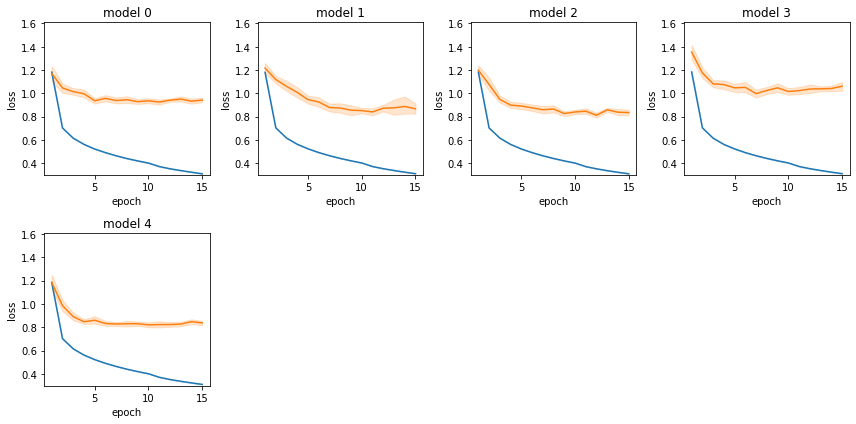

In [176]:
#plot history
#run_n=
print(f'run {run_n}')

#read
losses_train={}
losses_valid={}
for filename in os.listdir(target_dir+'/histories'):
    filename0=filename.split('.')[0]
    cl,r,m,s,c=filename0.split('_')[1:6]
    r,m=int(r),int(m)
    if cl=='I' and r==run_n:        
        with open(target_dir+'/histories/'+filename,'rb') as f:
            d=pickle.load(f)
        losses_train.setdefault(m,{'epoch':[],'loss':[]})
        losses_train[m]['epoch']+=list(range(1,1+len(d['loss'])))
        losses_train[m]['loss']+=d['loss']
        losses_valid.setdefault(m,{'epoch':[],'loss':[]})
        losses_valid[m]['epoch']+=list(range(1,1+len(d['val_loss'])))
        losses_valid[m]['loss']+=d['val_loss'] 
min_loss,max_loss=100.,0.
for m in losses_train:
    losses_train[m]=pd.DataFrame(losses_train[m])#,columns=['epoch','loss'])
    losses_valid[m]=pd.DataFrame(losses_valid[m])#,columns=['epoch','loss'])
    min_loss=min(min_loss,losses_train[m]['loss'].min())
    max_loss=max(max_loss,losses_valid[m]['loss'].max())
    
#plot
scale=3.
max_col=4
model_list=np.sort(list(losses_train.keys()))
n=len(model_list)
n_c=min(n,max_col)
n_r=n//n_c+int(n%n_c>0)
plt.figure(figsize=(n_c*scale,n_r*scale))
for i,k in enumerate(model_list):
    plt.subplot(n_r,n_c,i+1)
    sns.lineplot(data=losses_train[k],x='epoch',y='loss')
    sns.lineplot(data=losses_valid[k],x='epoch',y='loss')
    plt.ylim(min_loss,max_loss)
    plt.title(f'model {k}')
plt.tight_layout()
plt.show()

In [177]:
results_df_reduced

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
0,1,0,0,5,15.80,8.871302,0.460424,0.004504,0.976754,0.024119
1,3,0,0,20,19.10,10.412038,0.511685,0.007927,0.967365,0.024490
2,3,1,1,20,16.40,10.117208,0.508531,0.006644,0.945758,0.070822
3,3,2,2,20,16.65,9.137977,0.514077,0.008587,0.934336,0.030246
4,3,3,3,20,22.55,10.634972,0.510808,0.007954,1.026823,0.026832
5,3,4,4,20,14.80,7.445239,0.508091,0.005830,0.905904,0.024625
6,3,5,0,20,46.00,11.733892,0.548411,0.007132,1.005128,0.023261
7,3,6,1,20,46.50,9.854200,0.547862,0.006485,0.950768,0.073961
8,3,7,2,20,45.40,10.927512,0.548747,0.007677,0.978425,0.028596
9,3,8,3,20,39.80,9.490161,0.546885,0.006368,1.030530,0.025667


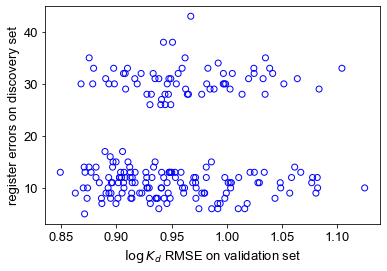

In [4]:
#valid performance vs regerr, regerr hist
c_run_ns=(3,7)
df=results_df[results_df['run'].isin(c_run_ns)]
df1=df[df['model'].isin([0,1,2,3,4])]
#df2=df[df['model'].isin([5,6,7,8,9])]
plt.figure()#figsize=(12,5))
#plt.subplot(121)
plt.scatter(df1['valid_rmse'].values,df1['reg_err'],edgecolors='blue',facecolors='none')
plt.xlabel('$\log K_d$ RMSE on validation set')
plt.ylabel('register errors on discovery set')
#plt.scatter(df2['valid_rmse'].values,df2['reg_err'],edgecolors='red',facecolors='none')
#plt.subplot(122)
#plt.hist(df1['reg_err'],bins=100,histtype='step',cumulative=1,color='blue')
#plt.hist(df2['reg_err'],bins=100,histtype='step',cumulative=1,color='red')
#plt.tight_layout()
fig_dir=os.getcwd()+'/figures_and_tables'
save_to=fig_dir+'/seqnn_I_regerr_vs_kd_err.pdf'
plt.savefig(save_to,dpi=500,format='pdf',bbox_inches='tight')
plt.show()

In [79]:
def remove_run(n):
    for d in ['images','results_json','weights']:
        cdir=target_dir+'/'+d
        for filename in os.listdir(cdir):
            if filename.startswith('run'):
                n1=int(filename.split('_')[2])
                if n1==n:
                    #print(d,filename)
                    os.remove(cdir+'/'+filename)
    os.remove(target_dir+f'/inputs/run_{n}.json')
#remove_run(4) 

In [37]:
#read parameters
c_run_n=1
with open(target_dir+f'/inputs/run_{c_run_n}.json') as f:
    params_all=json.load(f)
params_all={(x['model_n'],x['copy_n']):x for x in params_all}

In [38]:
params_all[0,0]

{'split_n': 0,
 'cl': 'I',
 'n_pep': 16,
 'max_registers': 4,
 'n_mhc': 26,
 'mhc_as_obj': False,
 'p00': [0.5, 0.0],
 'model': 'fully_connected',
 'n_hidden': [512, 256, 128],
 'actn': 'relu',
 'dropout_rate': 0.0,
 'batch_norm': True,
 'epochs': [20, 0],
 'batch_size': 32,
 'inference_batch_size': 128,
 'use_precomputed_data': False,
 'save_weights': True,
 'run_n': 1,
 'cpu_n': 7,
 'output_dir': '/scratch/lustre/vmikhayl/tmp_pmhc_nn',
 'model_n': 0,
 'copy_n': 0}

## load and evaluate

In [165]:
import tfold.nn.nn_predict as nn_predict
importlib.reload(nn_predict)
params_dir=target_dir+'/inputs'
weights_dir=target_dir+'/weights'

In [166]:
split_n=0

train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_i/train_{split_n}.pckl')
valid=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_i/valid_{split_n}.pckl')
test=pd.read_pickle('./data/pmhc_assays/test_i.pckl')

In [179]:
df=train.sample(5000)
model_list=[(3,i) for i in range(5)]+[(7,i) for i in range(5)]
df,model_list_full=nn_predict.predict(df,'I',mhc_as_obj=False,
                                      model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                                      keep_all_predictions=True)

/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [187]:
#df for models vs counts of (0,0)
x=np.stack(df[['tails_all','logkd_all']].apply(lambda x: [x['tails_all'][i] for i in np.argmin(x['logkd_all'],axis=1)],axis=1).values)
x=np.sum((x[:,:,0]==0)&(x[:,:,1]==0),axis=0)
model_regcounts=pd.DataFrame({'models':model_list_full,'counts':x})

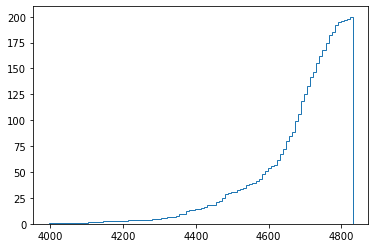

In [191]:
plt.figure()
plt.hist(model_regcounts['counts'].values,bins=100,cumulative=1,histtype='step')
plt.show()

In [194]:
df1=pmhcs_df[pmhcs_df['class']=='I']
df1,model_list_full1=nn_predict.predict(df1,'I',mhc_as_obj=True,
                                      model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                                      keep_all_predictions=True)

/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


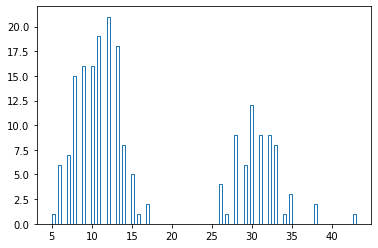

In [227]:
#df for models vs regerr number
x=np.stack(df1[['tails_all','logkd_all']].apply(lambda x: [x['tails_all'][i] for i in np.argmin(x['logkd_all'],axis=1)],axis=1).values)
x1=np.stack(df1['tails'])
x1=np.tile(x1.reshape(x1.shape[0],1,x1.shape[1]),[1,len(model_list_full),1])
z=((x-x1)!=0)
z=np.any(z,axis=2).astype(int)
z=np.sum(z,axis=0)
model_regerr=pd.DataFrame({'models':model_list_full1,'counts':z})
plt.figure()
plt.hist(model_regerr['counts'].values,histtype='step',bins=100)
plt.show()

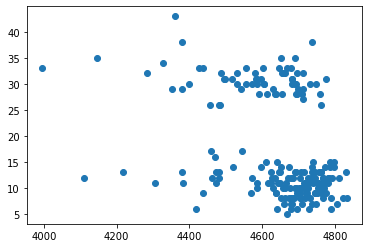

In [231]:
#join dataframes
df_merged=model_regcounts.merge(model_regerr,left_on='models',right_on='models')
df_merged.columns=['models','triv_reg','regerr']
plt.figure()
plt.scatter(df_merged['triv_reg'].values,df_merged['regerr'].values)
plt.show()

#conclusion: count of (0,0) is not diagnostic!

In [234]:
#compare performance for cleaned vs not cleaned model set
good_models=df_merged[df_merged['regerr']<23]['models'].values
good_models_ind=[model_list_full1.index(x) for x in good_models]

In [238]:
#errors with no model filtering
np.sum(df1['seqnn_tails']!=df1['tails'])

8

In [244]:
df1['logkd_filtered']=df1['logkd_all'].map(lambda x:x[good_models_ind,:])
x=df1['logkd_filtered'].map(lambda x:np.average(x,axis=0))
df1['seqnn_logkds_filtered']=[np.array([tuple(c) for c in zip(b,a)],
                                 dtype=[('tail',object),('logkd',float)])
                        for a,b in zip(x,df1['tails_all'])]
df1['seqnn_logkd_filtered']=x.map(np.min)
df1['seqnn_tails_filtered']=x.map(np.argmin)
df1['seqnn_tails_filtered']=df1[['seqnn_tails_filtered','tails_all']].apply(lambda x: x['tails_all'][x['seqnn_tails_filtered']],axis=1)    

In [245]:
#errors after model filtering
np.sum(df1['seqnn_tails_filtered']!=df1['tails'])

6

In [258]:
#save good models
import shutil

#copy weights
dir1=target_dir+'/weights'
dir2='./data/obj/seqnn/weights'
for filename in os.listdir(dir1):
    x=filename.split('_')
    if (len(x)>1) and (int(x[2]) in [3,7]):
        shutil.copy(dir1+'/'+filename,dir2+'/'+filename)
        
#save model list
with open('./data/obj/seqnn/model_list_I.pckl','wb') as f:
    pickle.dump(list(good_models),f)

## old

In [24]:
import tfold.nn.models
import importlib
importlib.reload(tfold.nn.models)
tfold_models=tfold.nn.models

target_dir='/scratch/vmikhayl/tmp_pmhc_nn'

In [25]:
params_pipeline={
        'n_pep':16,
        'n_mhc':26,
        'mhc_as_obj':False,
        'p00':0.,
        'max_registers':4,
        'regmask':'none'
        }

#read all params
params_dir=target_dir+'/inputs'
params_all={}
for filename in os.listdir(params_dir): 
    run_n=int(filename.split('.')[0].split('_')[1])
    with open(params_dir+'/'+filename) as f:
        d=json.load(f) 
    d={(run_n,x['model_n'],x['split_n'],x['copy_n']):x for x in d}
    params_all.update(d)

In [26]:
#prepare data

split_n=0

t0=time.time()
#load
train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_i/train_{split_n}.pckl')
valid=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_i/valid_{split_n}.pckl')
#test=pd.read_pickle('./data/pmhc_assays/test_i.pckl')
#encode
inputs_train=tfold.nn.pipeline.pipeline_i(train,params_pipeline)  
inputs_valid=tfold.nn.pipeline.pipeline_i(valid,params_pipeline)  
#inputs_test =tfold.nn.pipeline.pipeline_i(test, params)  
print('completed in {:4.2f} s'.format(time.time()-t0))        
    
#~100s on deimos
#~73s on cuda01

#encode structures
struct=c_df_i.copy()
params1=params_pipeline.copy()
params1['mhc_as_obj']=True
inputs_struct=tfold.nn.pipeline.pipeline_i(struct,params1)

completed in 95.62 s


In [43]:
#df copies
resdf_train=train[['pep','mhc','kd']].copy()
resdf_valid=valid[['pep','mhc','kd']].copy()
#resdf_test=test[['pep','mhc','kd']].copy()
resdf_struct=struct[['id','pep','mhc','netmhc_kd','tails','netmhc_tails']].copy()
resdf_struct['mhc']=resdf_struct['mhc'].map(lambda x: (x.info['species'],x.info['locus'],x.info['allele']))
resdf_struct['tails']=resdf_struct['tails'].map({'0_0':0,'-1_0':1,'1_0':2,'0_1':3,'0_5':3})
resdf_struct['netmhc_tails']=resdf_struct['netmhc_tails'].map({'0_0':0,'-1_0':1,'1_0':2,'0_1':3,'0_5':3})

In [44]:
#do inference

run_model_list=[(11,0)]#[(4,0),(5,0)] #[(21,0),(24,0)] #run_n and model_n of models to use
key_list=[]
for k in params_all:
    if k[:2] in run_model_list:
        if k[2]!=split_n:
            raise ValueError(f'check split_n for {k}')
        key_list.append(k)
print('total models:',len(key_list))

def _reduce_n_reg(a,b):
    return [x[:y] for x,y in zip(a,b)]

raw_train_res={}

t0=time.time()
for k in key_list:  
    #load model
    params=params_all[k]
    model_func=getattr(tfold_models,params['model'])        
    model=model_func(params)
    weight_path=target_dir+f'/weights/run_I_'+'_'.join([f'{kk}' for kk in k[:4]])
    model.load_weights(weight_path)
    #evaluate    
    raw_train_res[k]=model(inputs_train).numpy()
    resdf_train[k]=_reduce_n_reg(raw_train_res[k],inputs_train['n_reg'])    
    resdf_valid[k]=_reduce_n_reg(model(inputs_valid).numpy(),inputs_valid['n_reg'])
    #resdf_test[k]=_reduce_n_reg(model(inputs_test).numpy(),inputs_test['n_reg'])
    resdf_struct[k]=_reduce_n_reg(model(inputs_struct).numpy(),inputs_struct['n_reg'])    
print(f'completed in {time.time()-t0}')

total models: 32


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_re

/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_re

/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_re

/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_re

completed in 80.25249576568604


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [45]:
#compute averages
def _av_over_models(df):
    x=None
    for k in key_list:
        if x is None:
            x=df[k].copy()
        else:
            x+=df[k]
    df['av']=x/len(key_list)
    df['pred_logkd']=df['av'].map(np.min)
    df['pred_reg']=df['av'].map(np.argmin)
for df in [resdf_train,resdf_valid,resdf_struct]: #[resdf_train,resdf_valid,resdf_test,resdf_struct]:
    _av_over_models(df)

average reg error: 11.71875
average logKd error: 1.0120246494785554


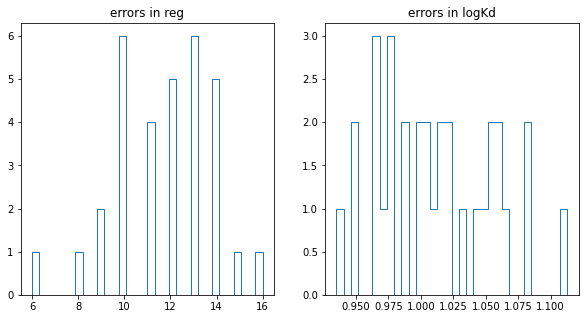

In [31]:
#errors for each model
regerr_distrib=[]
kd_err_distrib=[]
x=np.log10(valid['kd'])
#x=np.log10(test['kd'])
for k in key_list:
    regerr_distrib.append(np.sum(resdf_struct[k].map(np.argmin)!=resdf_struct['tails']))
    x1=resdf_valid[k].map(np.min)
    #x1=resdf_test[k].map(np.min)
    kd_err_distrib.append(np.average((x-x1)**2)**0.5)
print('average reg error:',np.average(regerr_distrib))
print('average logKd error:',np.average(kd_err_distrib))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(regerr_distrib,histtype='step',bins=32)
plt.title('errors in reg')
plt.subplot(122)
plt.hist(kd_err_distrib,histtype='step',bins=32)
plt.title('errors in logKd')
plt.show()

#9.55
#0.993

#11.72
#1.01

average reg error: 9.9375
average logKd error: 1.3981820108199978


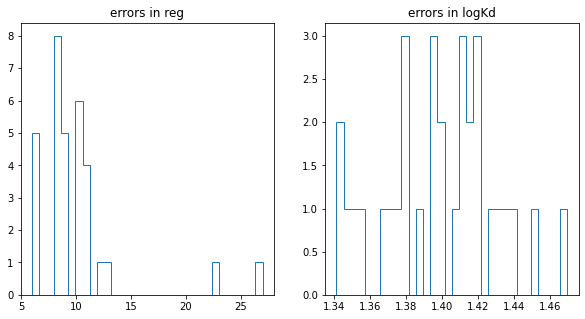

In [243]:
#############DO NOT RUN! FIGURE SAVED FROM PREVIOUS RUNS###########

#new regerr distribution similar! => std similar; probably large due to high copy num and tails in distrib

register errors 7 of 275
train
corr coef 0.964, rmse 0.359
valid
corr coef 0.828, rmse 0.886


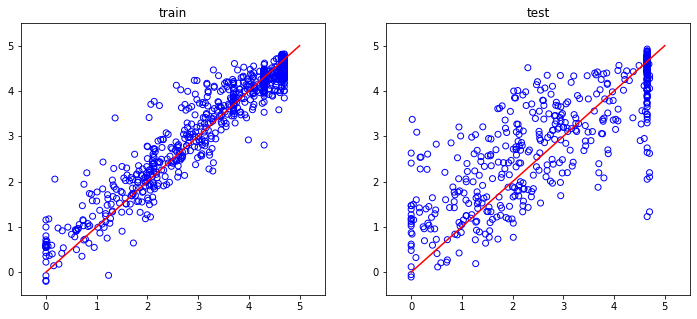

In [32]:
#count errors and plot
#registers
print('register errors {} of {}'.format(np.sum(resdf_struct['pred_reg']!=resdf_struct['tails']),len(resdf_struct)))
#Kd
plt.figure(figsize=(12,5))
plt.subplot(121)
print('train')
x1,x2=resdf_train['pred_logkd'].values,np.log10(train['kd'].values)
print('corr coef {:5.3f}, rmse {:5.3f}'.format(np.corrcoef([x1,x2])[0,1],np.mean((x1-x2)**2)**0.5))
ind=np.random.permutation(len(x1))[:1000]
plt.scatter(x2[ind],x1[ind],edgecolors='blue',facecolors='none')
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.plot([0,5],[0,5],color='red')
plt.title('train')
plt.subplot(122)
print('valid')
x1,x2=resdf_valid['pred_logkd'].values,np.log10(valid['kd'].values)
#print('test')
#x1,x2=resdf_test['pred_logkd'].values,np.log10(inputs_test[2])
print('corr coef {:5.3f}, rmse {:5.3f}'.format(np.corrcoef([x1,x2])[0,1],np.mean((x1-x2)**2)**0.5))
plt.scatter(x2,x1,edgecolors='blue',facecolors='none')
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.plot([0,5],[0,5],color='red')
plt.title('test')
plt.show()

#old: 7 of 275, train 0.383, valid --,    test 1.334
#new: 7 of 275, train 0.387, valid 0.868, test --

#11_0: 7, 0.359, 0.886

In [82]:
#save mask
n_mask=3

x=resdf_train['pred_reg'].values

#diversify registers for poor binders
#ind=np.nonzero((train['kd']>15000).values)[0]
#x[ind]=np.random.randint(4,size=(len(ind)))

#relax half of registers for 9mers
#i.e. for 9mers same as p00=0.5, while for others restrict reg to single predicted
ind=np.nonzero(train['pep'].map(len).values==9)[0]
ind=np.random.permutation(ind)[:len(ind)//2] #randomly choose half of indices
x=x[:,np.newaxis]
x=list(x)
for i in ind:
    x[i]=[0,1,2,3]

#x=x[:,np.newaxis]
with open(target_dir+f'/masks/mask_{n_mask}.pckl','wb') as f:
    pickle.dump(x,f)

In [105]:
#make masks interpolating between p00=0.5 and mask1
mask0=list(np.tile(np.arange(4)[np.newaxis,:],[len(resdf_train),1]))
ind=np.nonzero(train['pep'].map(len).values==9)[0]
ind=np.random.permutation(ind)[:len(ind)//2]       #randomly choose half of indices
for i in ind:
    mask0[i]=np.array([0])
with open(target_dir+f'/masks/mask_1.pckl','rb') as f:
    mask1=pickle.load(f)
for f in [0.,0.2,0.4,0.6,0.8,1.]:
    c_mask=mask0.copy()
    ind1=np.random.permutation(len(resdf_train))    
    ind1=ind1[:round(len(ind1)*f)]
    for i in ind1:
        c_mask[i]=mask1[i]
    mask_name=f'0_{int(10*f)}'
    print(mask_name,len(ind1))
    with open(target_dir+f'/masks/mask_{mask_name}.pckl','wb') as f:
        pickle.dump(c_mask,f)            

0_0 0
0_2 39450
0_4 78900
0_6 118349
0_8 157799
0_10 197249


In [115]:
mask_name='0_4'
with open(target_dir+f'/masks/mask_{mask_name}.pckl','rb') as f:
    c_mask=pickle.load(f) 
n=0    
for x in c_mask:
    if len(x)==1 and x[0]==1:
        print(x)
        n+=1
        if False:#n>=10:
            break

[1]
[1]
[1]
[1]
[1]


0 195476
1     12
2   1523
3    238


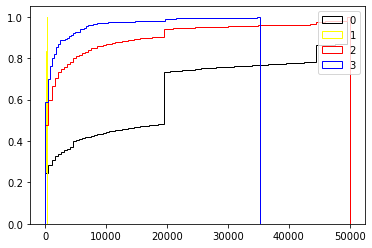

In [135]:
n_mask=1
with open(target_dir+f'/masks/mask_{n_mask}.pckl','rb') as f:
    x=pickle.load(f)
utils.print_hist(x[:,0])

colors=['black','yellow','red','blue']
plt.figure()
for i in range(4):
    plt.hist(train[x[:,0]==i]['kd'],histtype='step',bins=100,density=True,cumulative=1,color=colors[i])
plt.legend(np.arange(4))
plt.show()

In [139]:
k=(4,0,0,0)
params=params_all[k]
model_func=getattr(tfold_models,params['model'])        
model=model_func(params)

In [144]:
x=model(inputs_train).numpy()

/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [154]:
def _regmask_from_reglist(x,max_registers):    
    return np.array([np.isin(np.arange(max_registers),y).astype(int) for y in x])
with open(target_dir+f'/masks/mask_0_0.pckl','rb') as f:
    mask1=pickle.load(f)

y=inputs_train.copy()
y['regmask']=_regmask_from_reglist(mask1,params['max_registers'])

In [158]:
x+=(1-y['regmask'])*100.

In [159]:
regs_x=np.argmin(x,axis=1)

In [160]:
utils.print_hist(regs_x)

0 105615
1  37730
2  22698
3  31206


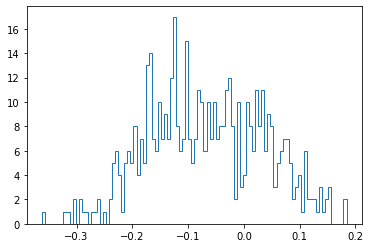

In [143]:
plt.figure()
plt.hist(x[:,0],bins=100,histtype='step')
plt.show()

In [98]:
with open(target_dir+'/reg1.pckl','rb') as f:
    x=pickle.load(f)
print(type(x))
print(len(x))
print([len(a) for a in x])

<class 'numpy.ndarray'>
12
[8, 8, 8, 11, 8, 8, 8, 8, 8, 8, 8, 8]


In [13]:
#debug mask vs p00
with open(target_dir+'/tmp_11_0.pckl','rb') as f:
    d0=pickle.load(f)
with open(target_dir+'/tmp_11_1.pckl','rb') as f:
    d1=pickle.load(f)
print(d0.keys())
#d0: mask, d1: p00

dict_keys(['peplen', 'mask', 'n_reg'])


In [17]:
#mask and n_reg summary by peplen
print('____________d0__________')
d=d0
for l in np.sort(np.unique(d['peplen'])):
    print(l)
    ind=(d['peplen']==l)
    print('n_reg')
    utils.print_hist(d['n_reg'][ind])
    print('mask')
    utils.print_hist(np.sum(d['mask'][ind],axis=1))
    print()
print('____________d1__________')
d=d1
for l in np.sort(np.unique(d['peplen'])):
    print(l)
    ind=(d['peplen']==l)
    print('n_reg')
    utils.print_hist(d['n_reg'][ind])
    print('mask')
    utils.print_hist(np.sum(d['mask'][ind],axis=1))
    print()

____________d0__________
8
n_reg
2 11367
mask
4 11367

9
n_reg
4 138452
mask
1 69220
4 69232

10
n_reg
4 37539
mask
4 37539

11
n_reg
4 8890
mask
4 8890

12
n_reg
4 372
mask
4 372

13
n_reg
4 397
mask
4 397

14
n_reg
4 232
mask
4 232

____________d1__________
8
n_reg
2 11367
mask
2 11367

9
n_reg
1 69325
4 69127
mask
1 69325
4 69127

10
n_reg
4 37539
mask
4 37539

11
n_reg
4 8890
mask
4 8890

12
n_reg
4 372
mask
4 372

13
n_reg
4 397
mask
4 397

14
n_reg
4 232
mask
4 232



In [12]:
d0['peplen'][:10],d1['peplen'][:10]

(array([ 9,  9,  9,  9, 11, 11,  9,  9,  9,  9]),
 array([ 9, 10, 10,  9,  9,  9, 10,  9,  9, 10]))

In [14]:
d0['n_reg'][:10],d1['n_reg'][:10]

(array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]), array([1, 4, 4, 4, 1, 4, 4, 1, 1, 4]))

In [15]:
d0['mask'][:10],d1['mask'][:10]

(array([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]]),
 array([[1, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 1, 1, 1]]))

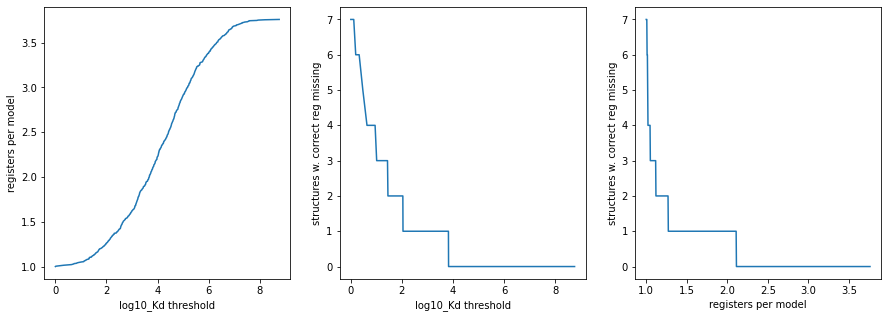

In [245]:
kd_tuples=(resdf_struct['av']-resdf_struct['pred_logkd']).values
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row]))
error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x in zip(kd_tuples,resdf_struct['tails']):        
        registers_kept+=np.sum(x[0]<=threshold)
        errors_kept+=int(x[0][x[1]]>threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel('log10_Kd threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel('log10_Kd threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.show()

In [247]:
#save registers
threshold=1.
n_errors=0
regs_to_save={}
for i,x in enumerate(kd_tuples):
    y=np.nonzero(x<=threshold)[0] #regs to save
    c_id=resdf_struct['id'].iloc[i]
    regs_to_save[c_id]=y
    if resdf_struct['tails'].iloc[i] not in y:
        n_errors+=1
print('correct reg missing for:',n_errors)
mean_reg=np.average([len(x) for x in regs_to_save.values()])
print('mean reg per pmhc:',mean_reg)
with open('./tmp/seqnn_regs_i.pckl','wb') as f:
    pickle.dump(regs_to_save,f)

correct reg missing for: 4
mean reg per pmhc: 1.0472727272727274


In [163]:
#compare AF and seq_nn reg errors 
df=df_modeled_i
af_wrong_ids=set(list(df[df['pdbnum']!=df['pdbnum_model']]['tid'].values))
seqnn_wrong_ids=set(list(resdf_struct[resdf_struct['pred_reg']!=resdf_struct['tails']]['id']))
print(f'af mistakes: {len(af_wrong_ids)}, seqnn mistakes: {len(seqnn_wrong_ids)}')
intersect_set=af_wrong_ids&seqnn_wrong_ids
print(f'intersection: {len(intersect_set)}')                   
print(df[df['tid'].isin(intersect_set)])

af mistakes: 26, seqnn mistakes: 7
intersection: 3
     tid       pepseq          mhc cl  cid                    pdbnum  \
tid                                                                    
58    58     HLEVQGYW     B*39:01   I    4           2,3,4,5,6,7,8,9   
69    69    AVKGVGTMV  BF2*012:01   I    5        1,2,3,4,5,7,8,9,10   
788  788  TMVMELIRMIK    A*11:263   I    8  2,3,4,5,51,52,59,6,7,8,9   

             pdbnum_template  match  pep_s  mhc_s   pep_lddt   mhc_lddt  \
tid                                                                       
58           1,2,3,4,5,7,8,9  False      7      0  91.511514  97.362967   
69         1,2,3,4,5,6,7,8,9  False      9     11  82.771431  95.410054   
788  09,1,2,3,4,5,51,6,7,8,9  False      9      0  65.862858  96.183965   

       pep_CA   pep_all    mhc_CA   mhc_all             pdbnum_model  
tid                                                                   
58   2.707094  4.361664  0.493105  1.145533          1,2,3,4,5,7,8,9  

In [164]:
#registers by pep len
df=df_modeled_i[['pepseq','pdbnum']].copy()
df['peplen']=df['pepseq'].map(len)
for x in np.sort(df['peplen'].unique()):
    print(x)
    print(df[df['peplen']==x]['pdbnum'].value_counts())

8
1,2,3,4,5,7,8,9    32
2,3,4,5,6,7,8,9     1
Name: pdbnum, dtype: int64
9
1,2,3,4,5,6,7,8,9     170
1,2,3,4,5,7,8,9,10      1
09,1,2,3,4,5,7,8,9      1
Name: pdbnum, dtype: int64
10
1,2,3,4,5,51,6,7,8,9    44
09,1,2,3,4,5,6,7,8,9     3
1,2,3,4,5,6,7,8,9,10     2
Name: pdbnum, dtype: int64
11
1,2,3,4,5,51,59,6,7,8,9     13
2,3,4,5,51,52,59,6,7,8,9     1
Name: pdbnum, dtype: int64
12
1,2,3,4,5,51,52,59,6,7,8,9    5
1,2,3,4,5,51,59,6,7,8,9,10    1
09,1,2,3,4,5,51,59,6,7,8,9    1
Name: pdbnum, dtype: int64


# cl II

## train on cluster

In [13]:
target_dir='/scratch/vmikhayl/tmp_pmhc_nn'
target_dir_apollo='/scratch/lustre/vmikhayl/tmp_pmhc_nn'

In [14]:
#get run number, set copy number, set input filename
#input file names: input_1.json,.. where 1,.. are run numbers
all_inputs=os.listdir(target_dir+'/inputs')
run_n=0
for x in all_inputs:    
    run_n=max(run_n,int(x[4:-5]))        
run_n+=1
input_filename=f'run_{run_n}.json'
copy_n=15
cpu_n=7 #5
print(f'run num: {run_n}, copy num: {copy_n}, cpu_n: {cpu_n}')

run num: 34, copy num: 15, cpu_n: 7


In [15]:
default_settings={    
    'split_n':0,
    'cl':'II',    
    'pep_mask':None,#[1,2,4,6,7,9],
    'regmasks':None, #['none'],   #['10','none'], #['none'],            
    'model':'fully_connected', #'attention_convolution', 'pairwise_energy_mini',# 
    'reduce_model':'reduce_model_min', #'reduce_model_sum'
    'use_tails':True,                                                            
    #'symmetrize_aa_matrix':False,
    #'initialize_from_contacts':True, #commented out in train_nn    
    #'n_values':32,            
    #'n_values_last':32,      
    #'kernel_size':3,         
    #'n_blocks':5,            
    #'reduce_x':False,        
    'n_hidden':[256]*5,   #[128,128,128,128],  #128*4 was standard without AF regmask, 256*5 with AF regmask
    #'aa_pair_features':4,
    #'reg_l1':0.001,
    'reg_l2':0.,
    'actn':'relu',
    #'reg':None,
    'dropout_rate':0.,
    'batch_norm':True,
    'epochs':[15],#[25], #40,
    'batch_size':32,    #32 #128
    'inference_batch_size':128,
    'use_crossentropy':False, #crossentropy loss instead of mean square; changes output function of kd!
    'save_weights':True,
    'save_image_losses':False,
    'save_image_regerrors':False
}    
    
default_settings['run_n']=run_n
default_settings['cpu_n']=cpu_n
default_settings['output_dir']=target_dir

In [16]:
#where to run
use_gpu=False #True 
lustre=True   #True for apollo/typhon, False for helios
exclusive=False

#choose settings
print('CHECK RUN NUM:',default_settings['run_n'])
mods=[]

mods.append({'split_n':0,'epochs':[70,5],'regmasks':['10_0','none'],'dropout_rate':0.6,'n_hidden':[256]*4})
mods.append({'split_n':1,'epochs':[70,5],'regmasks':['10_1','none'],'dropout_rate':0.6,'n_hidden':[256]*4})
mods.append({'split_n':2,'epochs':[70,5],'regmasks':['10_2','none'],'dropout_rate':0.6,'n_hidden':[256]*4})
mods.append({'split_n':3,'epochs':[70,5],'regmasks':['10_3','none'],'dropout_rate':0.6,'n_hidden':[256]*4})
mods.append({'split_n':4,'epochs':[70,5],'regmasks':['10_4','none'],'dropout_rate':0.6,'n_hidden':[256]*4})

mods.append({'split_n':0,'epochs':[70,5],'regmasks':['10_0','none'],'dropout_rate':0.6,'n_hidden':[256]*5})
mods.append({'split_n':1,'epochs':[70,5],'regmasks':['10_1','none'],'dropout_rate':0.6,'n_hidden':[256]*5})
mods.append({'split_n':2,'epochs':[70,5],'regmasks':['10_2','none'],'dropout_rate':0.6,'n_hidden':[256]*5})
mods.append({'split_n':3,'epochs':[70,5],'regmasks':['10_3','none'],'dropout_rate':0.6,'n_hidden':[256]*5})
mods.append({'split_n':4,'epochs':[70,5],'regmasks':['10_4','none'],'dropout_rate':0.6,'n_hidden':[256]*5})

#make inputs
all_inputs=[]
for i,x in enumerate(mods):    
    for k in range(copy_n):
        d=default_settings.copy()
        d['model_n']=i             
        d['copy_n']=k  
        if lustre:
            d['output_dir']=target_dir_apollo                    
        d.update(x)
        all_inputs.append(d)                                    
n_tasks=len(all_inputs)
print('total: {}'.format(n_tasks))    
path_to_input=target_dir+'/inputs/'+input_filename
with open(path_to_input,'w') as f:
    json.dump(all_inputs,f)
    
#make script
script_filename='run_nn.sh'
python_path='/data/vmikhayl/tfold/train_nn.py'
qos='short'
max_run_time=10*60 #in minutes  #INCREASE IF NECESSARY!
if lustre:
    tdir=target_dir_apollo
else:
    tdir=target_dir

if not use_gpu: #use cpu
    path_to_input_all=tdir+'/inputs/'+input_filename
    lines=[]
    lines.append('#!/bin/bash')
    lines.append('')
    #lines.append('#SBATCH --exclude=node60')  #exclude slow node!!!
    lines.append('#SBATCH --array=0-'+str(n_tasks-1))                   #run an array of n_tasks tasks
    lines.append('#SBATCH --output='+tdir+'/logs/output_{}_%a.txt'.format(run_n))  #here %a will evaluate to array task id
    lines.append('#SBATCH --error=' +tdir+'/logs/error_{}_%a.txt'.format(run_n))
    lines.append('#SBATCH --ntasks=1')  #each array element is one task
    lines.append('#SBATCH --cpus-per-task='+str(cpu_n))  #each task will use one core
    lines.append('#SBATCH --qos='+qos)  
    lines.append('#SBATCH --time='+str(max_run_time))     #maximal run time in minutes, same for each array task
    lines.append('')
    lines.append('input_file='+path_to_input_all)
    lines.append(f'srun python {python_path} $input_file $SLURM_ARRAY_TASK_ID')  
else: #use gpu           
    path_to_input_all=tdir+'/inputs/'+input_filename
    lines=[]
    lines.append('#!/bin/bash')
    lines.append('')
    #for x in slow_nodes:
    #    lines.append('#SBATCH --exclude=node{}'.format(x))     #exclude slow nodes        
    lines.append(f'#SBATCH --array=0-{n_tasks-1}')             #run an array of n_tasks tasks
    lines.append('#SBATCH --output='+tdir+'/logs/output_{}_%a.txt'.format(run_n))
    lines.append('#SBATCH --error=' +tdir+'/logs/error_{}_%a.txt'.format(run_n))
    lines.append(f'#SBATCH --ntasks=1')                        #each array element is one task
    if exclusive:
        lines.append(f'#SBATCH --exclusive')                   #request exclusive use of node, e.g. for hhblits    
    lines.append(f'#SBATCH --gpus=1')                      #one gpu per task will use one core   
    lines.append(f'#SBATCH --qos={qos}')  
    lines.append(f'#SBATCH --time={max_run_time}')             #maximal run time in minutes, same for each array task
    lines.append('')
    lines.append(f'input_file={path_to_input_all}')        
    lines.append(f'srun python {python_path} $input_file $SLURM_ARRAY_TASK_ID')

with open('./scripts/'+script_filename,'w') as f:
    f.writelines('\n'.join(lines))
os.chmod('./scripts/'+script_filename, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH)

CHECK RUN NUM: 34
total: 150


In [4]:
#run_n=33

In [17]:
#load results

d={'run':[],'model':[],'split':[],'copy':[]}
for filename in os.listdir(target_dir+'/results_json'):
    filename0=filename.split('.')[0]
    cl,r,m,s,c=filename0.split('_')[1:6]
    if cl=='II':
        d['run'].append(int(r))
        d['model'].append(int(m))
        d['split'].append(int(s))
        d['copy'].append(int(c))
        with open(target_dir+'/results_json/'+filename) as f:
            x=json.load(f)
        for k,v in x.items():
            d.setdefault(k,[]).append(v)
results_df=pd.DataFrame.from_dict(d)     
columns=results_df.columns
print(columns)
results_df=results_df[columns[[0,1,2,3,6,8,9,10,4,11]]]

results_df=results_df.rename({'struct_register_errors':'reg_err'},axis=1)
results_df=results_df.sort_values(['run','split','model','copy'])

if True: #print training times df for current run
    run_subset=[run_n] #[run_n]
    r_curr=results_df[results_df['run'].isin(run_subset)]
    print(r_curr[['run','model','copy','training_time','total_time']])
    #print('for run {:3d}: training time {:5.1f} s, total time {:5.1f} s'.format(run_n,
    #                                                                         r_curr.iloc[0]['training_time'],
    #                                                                         r_curr.iloc[0]['total_time']))
    print('structures evaluated:',int(r_curr.iloc[0]['struct_evaluated']))
results_df=results_df.drop(['training_time','total_time','struct_evaluated'],axis=1)
results_df_reduced=None
for k in ['reg_err','train_rmse','valid_rmse']: #,'train_corrcoef','valid_corrcoef']:  #corrcoef~rmse |corr|>0.9 => ignore
    df_mean=results_df.groupby(['run','model'])[k].mean().reset_index()
    if results_df_reduced is None:
        results_df_reduced=df_mean        
    else:
        results_df_reduced=results_df_reduced.merge(df_mean)
    df_std=results_df.groupby(['run','model'])[k].std().reset_index()
    df_std=df_std.rename({k:k+'_std'},axis=1)
    results_df_reduced=results_df_reduced.merge(df_std)
#put back split_n
df_split=results_df.groupby(['run','model'])['split'].mean().reset_index().astype(int) #head(1) causes trouble => mean,astype
results_df_reduced=results_df_reduced.merge(df_split)
#add copy count
df_copynum=results_df.groupby(['run','model'])['copy'].apply(len).reset_index()
df_copynum=df_copynum.rename({'copy':'copies'},axis=1)
results_df_reduced=results_df_reduced.merge(df_copynum)
c=list(results_df_reduced.columns)
results_df_reduced=results_df_reduced[c[:2]+c[-2:]+c[2:-2]]

#~300-450 s/model on apollo
#~520-620 s/model on typhon

Index(['run', 'model', 'split', 'copy', 'training_time', 'train_corrcoef',
       'train_rmse', 'valid_corrcoef', 'valid_rmse', 'struct_register_errors',
       'struct_evaluated', 'total_time'],
      dtype='object')
      run  model  copy  training_time   total_time
4413   34      0     0    2666.251741  2751.758454
2706   34      0     1    2726.985839  2802.897832
590    34      0     2    2745.319254  2823.018367
4535   34      0     3    2804.310054  2880.276319
2350   34      0     4    2614.705652  2691.481202
...   ...    ...   ...            ...          ...
20     34      9    10    2949.157824  3033.669135
528    34      9    11    2972.110871  3057.480913
5022   34      9    12    2960.769857  3045.649060
4047   34      9    13    2907.037747  2990.347592
724    34      9    14    2963.380020  3052.677828

[150 rows x 5 columns]
structures evaluated: 62


run 34


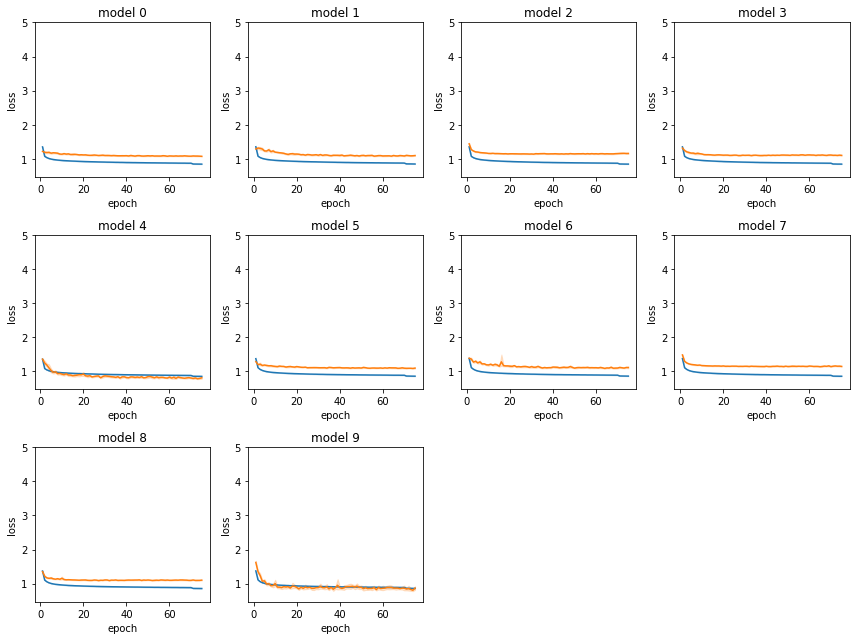

In [18]:
#plot history 
###NOTE: plots previously showed squared error (which is why also valid error in split 4 looks so small)
#run_n=18
print(f'run {run_n}')

#read
losses_train={}
losses_valid={}
for filename in os.listdir(target_dir+'/histories'):
    filename0=filename.split('.')[0]
    cl,r,m,s,c=filename0.split('_')[1:6]
    r,m=int(r),int(m)
    if cl=='II' and r==run_n:        
        with open(target_dir+'/histories/'+filename,'rb') as f:
            d=pickle.load(f)
        losses_train.setdefault(m,{'epoch':[],'loss':[]})
        losses_train[m]['epoch']+=list(range(1,1+len(d['loss'])))
        losses_train[m]['loss']+=d['loss']
        losses_valid.setdefault(m,{'epoch':[],'loss':[]})
        losses_valid[m]['epoch']+=list(range(1,1+len(d['val_loss'])))
        losses_valid[m]['loss']+=d['val_loss'] 
min_loss,max_loss=100.,0.
for m in losses_train:
    losses_train[m]=pd.DataFrame(losses_train[m])#,columns=['epoch','loss'])
    losses_valid[m]=pd.DataFrame(losses_valid[m])#,columns=['epoch','loss'])
    min_loss=min(min_loss,losses_train[m]['loss'].min())
    min_loss=min(min_loss,losses_valid[m]['loss'].min())
    max_loss=max(max_loss,losses_train[m]['loss'].max())
    max_loss=max(max_loss,losses_valid[m]['loss'].max())
max_loss=min(max_loss,5)

take_sqrt=True #MSE to RMSE, if the loss function is mean square
    
#plot
scale=3.
max_col=4
model_list=np.sort(list(losses_train.keys()))
n=len(model_list)
n_c=min(n,max_col)
n_r=n//n_c+int(n%n_c>0)
plt.figure(figsize=(n_c*scale,n_r*scale))
for i,k in enumerate(model_list):
    plt.subplot(n_r,n_c,i+1)
    dt=losses_train[k]
    dv=losses_valid[k]
    if take_sqrt:
        dt['loss']=dt['loss']**0.5
        dv['loss']=dv['loss']**0.5
    sns.lineplot(data=dt,x='epoch',y='loss')
    sns.lineplot(data=dv,x='epoch',y='loss')
    plt.ylim(min_loss,max_loss)
    plt.title(f'model {k}')
plt.tight_layout()
plt.show()

In [52]:
results_df_reduced[(results_df_reduced['run']==25)]

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
236,25,0,0,15,12.133333,2.850230,1.620132,0.004201,1.100881,0.021473
237,25,1,1,15,12.200000,1.373213,1.631743,0.008174,1.100655,0.023208
238,25,2,2,15,16.066667,1.751190,1.625040,0.008841,1.157327,0.025811
239,25,3,3,15,13.800000,2.651145,1.621835,0.005425,1.113588,0.026212
240,25,4,4,15,15.666667,2.288689,1.638935,0.014166,0.751338,0.042998
241,25,5,0,15,11.600000,2.229670,1.621468,0.011414,1.101937,0.015906
242,25,6,1,15,12.866667,1.597617,1.625493,0.007542,1.099280,0.016503
243,25,7,2,15,14.933333,1.869556,1.627296,0.016396,1.160803,0.032986
244,25,8,3,15,12.733333,1.709915,1.621818,0.007800,1.111487,0.014511
245,25,9,4,15,14.533333,2.030717,1.634138,0.011560,0.739742,0.027137


In [139]:
results_df_reduced[(results_df_reduced['run']==11)] #current no-AF default

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
26,11,0,0,15,22.466667,2.899918,0.619444,0.007051,1.073925,0.035012
27,11,1,1,15,21.800000,3.144156,0.622125,0.008680,1.110098,0.051172
28,11,2,2,15,22.733333,3.514595,0.623576,0.007376,1.136560,0.033860
29,11,3,3,15,20.666667,2.742956,0.620898,0.008249,1.169092,0.033703
30,11,4,4,15,19.866667,2.669047,0.621785,0.007614,0.672859,0.021355
31,11,5,0,15,20.800000,2.210365,0.626241,0.009279,1.037243,0.035065
32,11,6,1,15,20.800000,2.833473,0.627668,0.008457,1.063677,0.063862
33,11,7,2,15,22.066667,3.453087,0.623535,0.005244,1.118088,0.026594
34,11,8,3,15,21.666667,3.221949,0.621478,0.005700,1.149129,0.047508
35,11,9,4,15,22.400000,2.848559,0.626622,0.009659,0.687217,0.026436


In [18]:
results_df_reduced[(results_df_reduced['run']==18)]

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
126,18,0,0,15,13.200000,2.111195,1.660050,0.013735,1.095818,0.012188
127,18,1,1,15,12.933333,1.579632,1.671938,0.017805,1.113801,0.015998
128,18,2,2,15,15.266667,1.486447,1.664761,0.012234,1.184366,0.025685
129,18,3,3,15,12.466667,1.959106,1.667153,0.021648,1.128807,0.046070
130,18,4,4,15,13.933333,2.051712,1.671106,0.015749,0.831658,0.034892
131,18,5,0,15,14.266667,2.814926,0.855928,0.022955,1.089774,0.008881
132,18,6,1,15,14.200000,3.488757,0.862878,0.023404,1.134318,0.024701
133,18,7,2,15,17.600000,2.557901,0.858885,0.025929,1.187706,0.018148
134,18,8,3,15,15.066667,1.791514,0.856571,0.022878,1.100385,0.011416
135,18,9,4,15,15.400000,2.323790,0.853030,0.017777,0.854884,0.037740


In [19]:
results_df_reduced[(results_df_reduced['run']==31)]

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
301,31,0,0,15,13.000000,2.138090,0.814993,0.012323,1.085317,0.016675
302,31,1,1,15,12.266667,2.548576,0.823656,0.010525,1.094638,0.032498
303,31,2,2,15,15.866667,1.726543,0.821847,0.019461,1.138706,0.020033
304,31,3,3,15,13.200000,2.426049,0.818017,0.012807,1.100997,0.013287
305,31,4,4,15,12.933333,1.667619,0.826609,0.018623,0.860422,0.080098
306,31,5,0,15,27.866667,4.596065,0.847338,0.037948,1.078766,0.018558
307,31,6,1,15,27.800000,3.098387,0.830694,0.023263,1.196704,0.047906
308,31,7,2,15,28.466667,2.166850,0.836696,0.026983,1.186938,0.021681
309,31,8,3,15,29.133333,2.587516,0.852322,0.023008,1.100690,0.014848
310,31,9,4,15,25.666667,2.636737,0.844733,0.036428,0.879540,0.072385


In [7]:
results_df_reduced[(results_df_reduced['run']==33)]

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
321,33,0,0,15,12.200000,2.596701,0.811400,0.027203,1.087387,0.028183
322,33,1,1,15,12.333333,1.290994,0.818564,0.021334,1.096031,0.022185
323,33,2,2,15,15.933333,2.433888,0.806054,0.022625,1.144997,0.021381
324,33,3,3,15,12.466667,2.133631,0.817419,0.024594,1.112286,0.022683
325,33,4,4,15,12.733333,2.016598,0.817608,0.026193,0.811469,0.064697
326,33,5,0,15,13.000000,1.851640,0.822690,0.021789,1.107417,0.037930
327,33,6,1,15,11.866667,1.807392,0.814415,0.010913,1.105689,0.043544
328,33,7,2,15,15.200000,2.455315,0.831399,0.058683,1.152816,0.050729
329,33,8,3,15,12.200000,2.007130,0.824109,0.032173,1.114674,0.022633
330,33,9,4,15,13.200000,2.730777,0.833365,0.037967,0.894122,0.171993


In [19]:
results_df_reduced[(results_df_reduced['run']==34)]

,run,model,split,copies,reg_err,reg_err_std,train_rmse,train_rmse_std,valid_rmse,valid_rmse_std
331,34,0,0,15,14.000000,2.449490,0.802588,0.029796,1.073354,0.018733
332,34,1,1,15,12.666667,2.636737,0.795645,0.021299,1.096048,0.021919
333,34,2,2,15,16.600000,2.097618,0.800063,0.036464,1.157469,0.036478
334,34,3,3,15,13.266667,1.579632,0.790610,0.021404,1.100740,0.022195
335,34,4,4,15,14.733333,2.153624,0.798839,0.026015,0.806240,0.061171
336,34,5,0,15,13.066667,1.869556,0.794552,0.014306,1.091449,0.033835
337,34,6,1,15,13.466667,2.474633,0.802838,0.025301,1.108128,0.055369
338,34,7,2,15,17.800000,2.704494,0.790544,0.016265,1.140983,0.019770
339,34,8,3,15,14.000000,2.591194,0.807488,0.025178,1.101568,0.023745
340,34,9,4,15,15.000000,2.035401,0.805519,0.016721,0.866950,0.119808


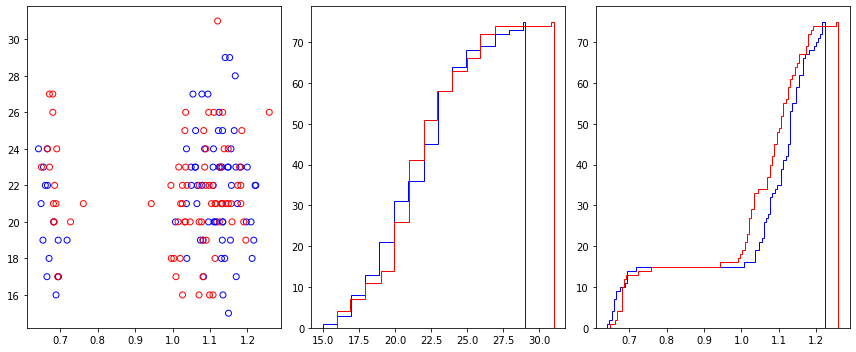

In [418]:
#valid performance vs regerr, regerr hist
c_run_n=11
df=results_df[results_df['run']==c_run_n]
df1=df[df['model'].isin([0,1,2,3,4])]
df2=df[df['model'].isin([5,6,7,8,9])]
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.scatter(df1['valid_rmse'].values,df1['reg_err'],edgecolors='blue',facecolors='none')
plt.scatter(df2['valid_rmse'].values,df2['reg_err'],edgecolors='red',facecolors='none')
plt.subplot(132)
plt.hist(df1['reg_err'],bins=100,histtype='step',cumulative=1,color='blue')
plt.hist(df2['reg_err'],bins=100,histtype='step',cumulative=1,color='red')
plt.subplot(133)
plt.hist(df1['valid_rmse'],bins=100,histtype='step',cumulative=1,color='blue')
plt.hist(df2['valid_rmse'],bins=100,histtype='step',cumulative=1,color='red')
plt.tight_layout()
plt.show()

In [12]:
def remove_run(n):
    for d in ['images','results_json','weights','histories']:
        cdir=target_dir+'/'+d
        for filename in os.listdir(cdir):
            if filename.startswith('run'):
                n1=int(filename.split('_')[2])
                if n1==n:
                    #print(d,filename)
                    os.remove(cdir+'/'+filename)
    os.remove(target_dir+f'/inputs/run_{n}.json')
#remove_run(34)

In [34]:
#read parameters
c_run_n=29
with open(target_dir+f'/inputs/run_{c_run_n}.json') as f:
    params_all=json.load(f)
params_all={(x['model_n'],x['copy_n']):x for x in params_all}

In [198]:
#debug masks
with open(target_dir+'/masks/mask_3_0.pckl','rb') as f:
    mask=pickle.load(f)
print(len(mask))
train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_0.pckl')
print(len(train))
print(train.columns)

114611
114611
Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')


In [201]:
for i,m in enumerate(mask):
    if len(m)<3:
        print(i)
        break

15


In [203]:
mask[15],train.iloc[15]

([(2, 4)],
 pep          SEFAYGSFVRTVSLP
 mhc_a    (9606, DPA1, 01:03)
 mhc_b    (9606, DPB1, 02:01)
 kd                  6.989986
 Name: 16, dtype: object)

In [214]:
train.iloc[15],mask[15]

(pep          SEFAYGSFVRTVSLP
 mhc_a    (9606, DPA1, 01:03)
 mhc_b    (9606, DPB1, 02:01)
 kd                  6.989986
 Name: 16, dtype: object,
 [(2, 4)])

In [215]:
results_df[results_df['pep']=='SEFAYGSFVRTVSLP']

,pmhc_id,model_id,tpl_tails,best_score,best_mhc_score,register_identified,af_tails,pep_lddt,mhc_lddt,class,pep,mhc_a,mhc_b,kd,n_reg_filtered,af_n_reg,seqnn_logkd,lddt_score
16065,6948,0,"(2, 4)",12,0,True,"(2, 4)","[[P 08, 86.62490878574316], [P 09, 94.4769...","[[M 61 , 96.42978132658224], [M 70 , 98.5513...",II,SEFAYGSFVRTVSLP,"(9606, DPA1, 01:03)","(9606, DPB1, 02:01)",6.989986,1,1,1.265290,1.411088
30301,11891,0,"(2, 4)",16,3,True,"(2, 4)","[[P 08, 86.16487724130273], [P 09, 94.5628...","[[M 61 , 96.51987454266798], [M 70 , 98.3760...",II,SEFAYGSFVRTVSLP,"(9606, DPA1, 01:03)","(9606, DPB1, 04:01)",14.535835,1,1,1.223297,1.714039
39192,14659,0,"(1, 5)",16,0,True,"(1, 5)","[[P 09, 63.68264134926721], [P 1 , 56.4257...","[[M 61 , 93.23574753362435], [M 70 , 93.7797...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 11:01)",21.915604,4,4,3.617402,3.519457
39193,14659,3,"(2, 4)",21,7,True,"(2, 4)","[[P 08, 90.49510518573152], [P 09, 96.1093...","[[M 61 , 97.4364766438344], [M 70 , 95.19971...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 11:01)",21.915604,4,4,3.843159,2.568549
39194,14659,4,"(3, 3)",13,0,True,"(3, 3)","[[P 07, 60.415456631861154], [P 08, 79.707...","[[M 61 , 94.98122489252079], [M 70 , 96.2920...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 11:01)",21.915604,4,4,3.315814,3.012794
39195,14659,6,"(4, 2)",14,0,True,"(4, 2)","[[P 06, 54.76220992964226], [P 07, 72.4740...","[[M 61 , 97.32642678137552], [M 70 , 98.5434...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 11:01)",21.915604,4,4,2.489156,1.045287
76291,24744,0,"(1, 5)",29,13,False,"(1, 5)","[[P 09, 85.3758624234615], [P 1 , 93.97355...","[[M 61 , 97.28156969593202], [M 70 , 93.7720...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 07:01)",65.559212,5,5,3.708813,2.916010
76292,24744,3,"(2, 4)",28,14,True,"(2, 4)","[[P 08, 91.03924991332677], [P 09, 96.4688...","[[M 61 , 97.87048214176325], [M 70 , 97.1088...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 07:01)",65.559212,5,5,3.197676,1.778022
76293,24744,5,"(3, 3)",28,14,True,"(3, 3)","[[P 07, 67.94489873835118], [P 08, 88.4515...","[[M 61 , 96.87693394654717], [M 70 , 97.7236...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 07:01)",65.559212,5,5,2.187886,1.894406
76294,24744,7,"(4, 2)",29,14,True,"(4, 2)","[[P 06, 58.652424318803234], [P 07, 79.581...","[[M 61 , 97.14884859908068], [M 70 , 97.7269...",II,SEFAYGSFVRTVSLP,"(9606, DRA, 01:01)","(9606, DRB1, 07:01)",65.559212,5,5,3.352253,1.981554


In [28]:
e1=1.6
e2=2.6
f=0.14
((e2**2-(1-f)*e1**2)/f)**0.5

5.706137047074843

In [ ]:
pd.read_pickle

## load and evaluate

In [12]:
import tfold.nn.nn_predict as nn_predict
import tfold.config
importlib.reload(tfold.config)
importlib.reload(nn_predict)
params_dir=target_dir+'/inputs'
weights_dir=target_dir+'/weights'

In [272]:
#to infer masks, load all 5 later
#split_n=0

#train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl')
#valid=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/valid_{split_n}.pckl')
#test=pd.read_pickle('./data/pmhc_assays/test_ii.pckl')

In [13]:
#model_list=[(8,i) for i in range(5,9)]
#model_list=[(9,)]
#model_list=[(10,i) for i in range(5,9)]
#model_list=[(11,)]

#model_list=[(14,10+i) for i in range(5)] #mask 4 with highest dropout
#model_list=[(17,)]
#model_list=[(18,5+i) for i in range(5)] #mask 6; 0-4: [75], 5-9: [75,5]
#model_list=[(25,)]
#model_list=[(31,i) for i in range(5)] #models with AF mask
model_list=[(33,)]

df=pmhcs_df[pmhcs_df['class']=='II']
df=nn_predict.predict(df,'II',mhc_as_obj=True,
                      model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                      keep_all_predictions=False)

making Kd predictions for 62 pmhcs...


2022-10-31 09:26:06.180664: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [14]:
#seqnn regerrors:
#run 8: 21 with pepmask, 24 without
#run 9: 21
#run 10: 25 with pepmask, 20 without (all no tails)
#run 11: 15!!

#run 14_(10-14) (mask 4 with dropout 0.6): 10

#run 17 (AF mask 7, mpr=5): 11

#run 18 0-4 ([75])  : 10
#run 18 5-9 ([75,5]): 12

#run 31 (canonical run with AF mask, first step): 12
#run 33 (second step, mask 10): 11

len(df[df['tails']!=df['seqnn_tails']])

11

In [400]:
#predict for train, infer and save masks  #masks 1_% derived from run 8

n_mask='2' #'1'
model_list=[(8,i) for i in range(5,9)] #for each split_n, use all models for predictions!

def _reduce_registers_1(x,threshold=1.): #keep registers within x10 of the top  #for mask 1
    return x['tail'][x['logkd']<min(x['logkd'])+threshold]    

def _reduce_registers_2(x,threshold=1000.): #true kd<1000: predicted, otherwise all #for mask 2
    if x['kd']<threshold:
        return [x['seqnn_tails']]
    else:
        return nn_utils.generate_registers_II(len(x['pep']))

t0=time.time()
for split_n in [0,1,2,3,4]:
    train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl')    
    df1=train.copy()    
    t1=time.time()
    df1=nn_predict.predict(df1,'II',mhc_as_obj=False,
                           model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                           keep_all_predictions=False)
    print(f'split_n {split_n} prediction in {time.time()-t1}')    
    #regs_to_save=df1['seqnn_logkds_all'].map(_reduce_registers1)
    regs_to_save=df1.apply(_reduce_registers_2,axis=1)
    #compare av. number of registers before and after reduction
    print('av. n. reg. all:',df1['seqnn_logkds_all'].map(len).mean())
    print('av. n. reg. reduced:',regs_to_save.map(len).mean())
    #save mask    
    with open(target_dir+f'/masks/mask_{n_mask}_{split_n}.pckl','wb') as f:
        pickle.dump(regs_to_save.values,f)   
        
print(f'all done in {time.time()-t0}')

#341*5/60~28 min expected (29.8min actual)

evaluating 80 trained models on 114611 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


split_n 0 prediction in 353.340190410614
av. n. reg. all: 7.279030808561133
av. n. reg. reduced: 4.525647625446074
evaluating 80 trained models on 113576 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


split_n 1 prediction in 348.40260004997253
av. n. reg. all: 7.284170951609495
av. n. reg. reduced: 4.520981545396915
evaluating 80 trained models on 114226 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


split_n 2 prediction in 352.6024534702301
av. n. reg. all: 7.278631835133857
av. n. reg. reduced: 4.511092045593823
evaluating 80 trained models on 114763 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


split_n 3 prediction in 355.532509803772
av. n. reg. all: 7.2798724327527164
av. n. reg. reduced: 4.522712023910145
evaluating 80 trained models on 113696 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-tf-gpu/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


split_n 4 prediction in 348.86694741249084
av. n. reg. all: 7.278945609344216
av. n. reg. reduced: 4.543493174781874
all done in 1768.7009854316711


In [422]:
#save models (from run 11)
import shutil

#copy weights
dir1=target_dir+'/weights'
dir2='./data/obj/seqnn/weights'
for filename in os.listdir(dir1):
    x=filename.split('_')
    if (len(x)>1) and (int(x[2])==11):
        shutil.copy(dir1+'/'+filename,dir2+'/'+filename)
        
good_models=[(11,)]        
#save model list
with open('./data/obj/seqnn/model_list_II.pckl','wb') as f:
    pickle.dump(list(good_models),f)

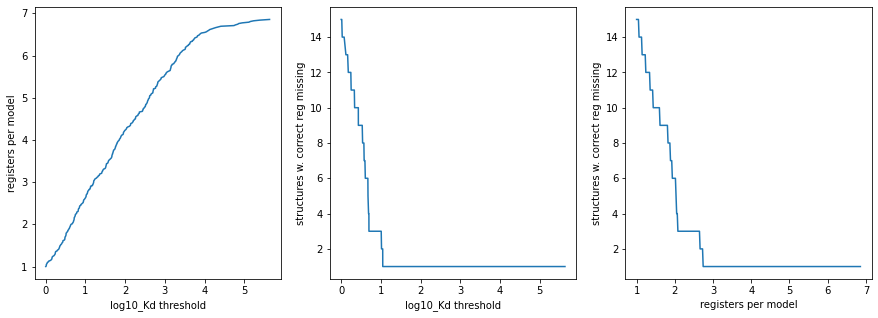

In [423]:
#regerror plot

def _subtract_mean(x):
    y=x['seqnn_logkds_all'].copy()
    y['logkd']=y['logkd']-x['seqnn_logkd']
    return y
def _pick_register(x,y,threshold):
    xx=np.stack(x['tail'])
    xx=x[(xx[:,0]==y[0])&(xx[:,1]==y[1])]
    if (len(xx)==0) or (xx[0]['logkd']>threshold):
        return 1    
    else:
        return 0

df=df #struct_ii
kd_tuples=df.apply(_subtract_mean,axis=1)
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row['logkd']]))

error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x,y in zip(kd_tuples,df['tails']):
        registers_kept+=np.sum(x['logkd']<=threshold)        
        errors_kept+=_pick_register(x,y,threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel('log10_Kd threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel('log10_Kd threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.show()

In [238]:
#errors with no model filtering
np.sum(df1['seqnn_tails']!=df1['tails'])

8

In [244]:
df1['logkd_filtered']=df1['logkd_all'].map(lambda x:x[good_models_ind,:])
x=df1['logkd_filtered'].map(lambda x:np.average(x,axis=0))
df1['seqnn_logkds_filtered']=[np.array([tuple(c) for c in zip(b,a)],
                                 dtype=[('tail',object),('logkd',float)])
                        for a,b in zip(x,df1['tails_all'])]
df1['seqnn_logkd_filtered']=x.map(np.min)
df1['seqnn_tails_filtered']=x.map(np.argmin)
df1['seqnn_tails_filtered']=df1[['seqnn_tails_filtered','tails_all']].apply(lambda x: x['tails_all'][x['seqnn_tails_filtered']],axis=1)    

In [245]:
#errors after model filtering
np.sum(df1['seqnn_tails_filtered']!=df1['tails'])

6

In [7]:
import tfold.nn.models
import importlib
importlib.reload(tfold.nn.models)
tfold_models=tfold.nn.models

target_dir='/scratch/vmikhayl/tmp_pmhc_nn'

In [8]:
params_pipeline={
        'n_pep':9,
        'n_mhc':30,
        'mhc_as_obj':False,
        'max_registers':22-9+1        
        }
#read all params
params_dir=target_dir+'/inputs'
params_all={}
for filename in os.listdir(params_dir): 
    run_n=int(filename.split('.')[0].split('_')[1])
    with open(params_dir+'/'+filename) as f:
        d=json.load(f) 
    d={(run_n,x['model_n'],x['split_n'],x['copy_n']):x for x in d}
    params_all.update(d)

In [9]:
#prepare data

split_n=0

t0=time.time()
#load
train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl')
train=train.reset_index(drop=True)
valid=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/valid_{split_n}.pckl')
valid=valid.reset_index(drop=True)
#test=pd.read_pickle('./data/pmhc_assays/test_ii.pckl')
#encode
inputs_train=tfold.nn.pipeline.pipeline_ii(train,params_pipeline)  
inputs_valid=tfold.nn.pipeline.pipeline_ii(valid,params_pipeline)  
#inputs_test =tfold.nn.pipeline.pipeline_ii(test, params)  
print('completed in {:4.2f} s'.format(time.time()-t0))            

#encode structures
struct=c_df_ii.copy()
struct=struct.reset_index(drop=True)
params1=params_pipeline.copy()
params1['mhc_as_obj']=True
inputs_struct=tfold.nn.pipeline.pipeline_ii(struct,params1)

completed in 99.61 s


In [10]:
#df copies
resdf_train=train[['pep','mhc_a','mhc_b','kd']].copy()
resdf_valid=valid[['pep','mhc_a','mhc_b','kd']].copy()
#resdf_test=test[['pep','mhc_a','mhc_b','kd']].copy()
resdf_struct=struct[['id','pep','mhc_a','mhc_b','netmhc_kd','tails','netmhc_tails']].copy()
resdf_struct['mhc_a']=resdf_struct['mhc_a'].map(lambda x: (x.info['species'],x.info['locus'],x.info['allele']))
resdf_struct['mhc_b']=resdf_struct['mhc_b'].map(lambda x: (x.info['species'],x.info['locus'],x.info['allele']))
resdf_struct['tails']=resdf_struct['tails'].astype(int)
resdf_struct['netmhc_tails']=resdf_struct['netmhc_tails'].astype(int)

In [293]:
#do inference

run_model_list=[(35,0)] #run_n and model_n of models to use
key_list=[]
for k in params_all:
    if k[:2] in run_model_list:
        if k[2]!=split_n:
            raise ValueError(f'check split_n for {k}')
        key_list.append(k)
print('total models:',len(key_list))

def _reduce_n_reg(a,b):
    return [x[:y] for x,y in zip(a,b)]

raw_train_res={}

#inf_bs=2048
#n=len(resdf_train)
#n_batches_inf=n//inf_bs+int(n%inf_bs)

t0=time.time()
for k in key_list:  
    
    #load model
    params=params_all[k]
    model_func=getattr(tfold_models,params['model'])        
    model=model_func(params)
    weight_path=target_dir+f'/weights/run_II_'+'_'.join([f'{kk}' for kk in k[:4]])
    model.load_weights(weight_path)
    
    #evaluate    
    
    #with batching (necessary for energy models): TOO SLOW!
    #train_pred=[]
    #for i in range(n_batches_inf):
    #    c_input={k:v[i*inf_bs:(i+1)*inf_bs] for k,v in inputs_train.items()}
    #    train_pred.append(model(c_input).numpy())
    #raw_train_res[k]=np.concatenate(train_pred)       
    #no batching
    raw_train_res[k]=model(inputs_train).numpy()
        
    resdf_train[k]=_reduce_n_reg(raw_train_res[k],inputs_train['n_reg'])    
    resdf_valid[k]=_reduce_n_reg(model(inputs_valid).numpy(),inputs_valid['n_reg'])
    #resdf_test[k]=_reduce_n_reg(model(inputs_test).numpy(),inputs_test['n_reg'])
    resdf_struct[k]=_reduce_n_reg(model(inputs_struct).numpy(),inputs_struct['n_reg'])    
print(f'completed in {time.time()-t0}')

total models: 16


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-06-15 01:32:18.483612: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36364930560 exceeds 10% of free system memory.
2022-06-15 01:32:19.560806: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36364930560 exceeds 10% of free system memory.
2022-06-15 01:32:21.259868: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36364930560 exceeds 10% of free system memory.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_referenc

/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input

completed in 131.83617115020752


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['n_reg', 'regmask', 'tails'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [294]:
#compute averages
def _av_over_models(df):
    x=None
    for k in key_list:
        if x is None:
            x=df[k].copy()
        else:
            x+=df[k]
    df['av']=x/len(key_list)
    df['pred_logkd']=df['av'].map(np.min)
    df['pred_reg']=df['av'].map(np.argmin)
for df in [resdf_train,resdf_valid,resdf_struct]:#[resdf_train,resdf_valid,resdf_test,resdf_struct]:
    _av_over_models(df)

average reg error: 18.5625
average logKd error: 1.2439985137420124


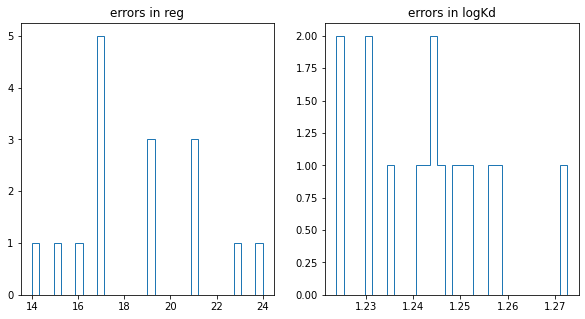

In [295]:
#errors for each model
regerr_distrib=[]
kd_err_distrib=[]
x=np.log10(valid['kd'])
#x=np.log10(test['kd'])
for k in key_list:
    regerr_distrib.append(np.sum(resdf_struct[k].map(np.argmin)!=resdf_struct['tails']))
    x1=resdf_valid[k].map(np.min)
    #x1=resdf_test[k].map(np.min)
    kd_err_distrib.append(np.average((x-x1)**2)**0.5)
print('average reg error:',np.average(regerr_distrib))
print('average logKd error:',np.average(kd_err_distrib))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(regerr_distrib,histtype='step',bins=32)
plt.title('errors in reg')
plt.subplot(122)
plt.hist(kd_err_distrib,histtype='step',bins=32)
plt.title('errors in logKd')
plt.show()

#24.4, 1.20
#18.6, 1.16 (14_1 old..?)

#21.6 (14_0)
#19.4 1.20
#20.2, 1.185
#19.0, 1.185
#19.0, 1.204

#new chain
#12-1 (tails, no mask) 24.4, 1.202
#20-0 20.06, 1.20
#21-0 19.4, 1.2
#22-0 19.0 1.2
#23-0 19.9 1.19

#new chain
#24_0..4 20.7 1.19
#25_0..4 19.6 1.19
#26_0..4 19.4 1.18

#new chain: n_hidden 20-40-60, 50*3 models
#25.6, 1.23

#energy model with mask 10
#18.6, 1.24

average reg error: 28.375
average logKd error: 1.1805068551890932


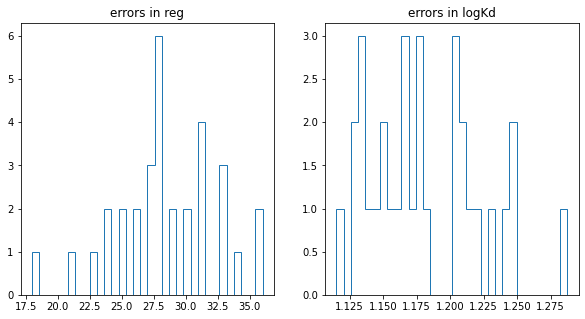

In [254]:
### DO NOT RUN: KEEP OLD PLOTS ###

register errors 15 of 58
train
corr coef 0.662, rmse 0.918
valid
corr coef 0.521, rmse 1.217


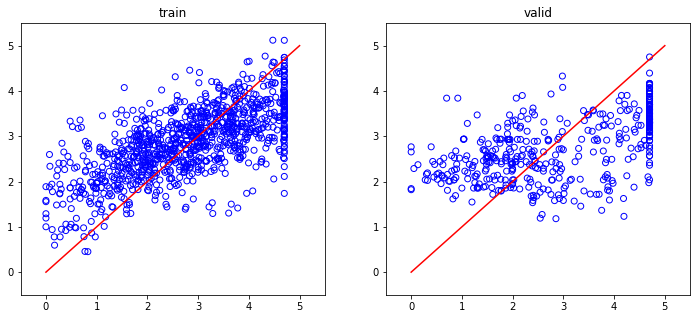

In [296]:
#count errors and plot
#registers
print('register errors {} of {}'.format(np.sum(resdf_struct['pred_reg']!=resdf_struct['tails']),len(resdf_struct)))
#Kd
plt.figure(figsize=(12,5))
plt.subplot(121)
print('train')
x1,x2=resdf_train['pred_logkd'].values,np.log10(train['kd'].values)
print('corr coef {:5.3f}, rmse {:5.3f}'.format(np.corrcoef([x1,x2])[0,1],np.mean((x1-x2)**2)**0.5))
ind=np.random.permutation(len(x1))[:1000]
plt.scatter(x2[ind],x1[ind],edgecolors='blue',facecolors='none')
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.plot([0,5],[0,5],color='red')
plt.title('train')
plt.subplot(122)
print('valid')
x1,x2=resdf_valid['pred_logkd'].values,np.log10(valid['kd'].values)
#print('test')
#x1,x2=resdf_test['pred_logkd'].values,np.log10(inputs_test[2])
print('corr coef {:5.3f}, rmse {:5.3f}'.format(np.corrcoef([x1,x2])[0,1],np.mean((x1-x2)**2)**0.5))
plt.scatter(x2,x1,edgecolors='blue',facecolors='none')
plt.xlim(-0.5,5.5)
plt.ylim(-0.5,5.5)
plt.plot([0,5],[0,5],color='red')
plt.title('valid')
plt.show()

#old:   26 of 58, train 0.762, valid -----,    test 1.060
#12-1:  20 of 58, train 0.715, valid 1.134,    test -----
#13-1:  16 of 58, train 0.575, valid 1.102

#14-0: 19, 0.593, 1.140
#15-0: 16, 0.573, 1.137
#16-0: 18, 0.566, 1.124
#17-0: 17, 0.566, 1.126
#18-0: 18, 0.561, 1.142

#new chain
#12-1 (tails, no mask) 20, 0.715, 1.134
#20-0 17, 0.594, 1.135
#21-0 16, 0.570, 1.132
#22-0 18, 0.566, 1.139
#23-0 18, 0.560, 1.131

#new chain
#24-0..4 18, 0.581, 1.130
#25-0..4 18, 0.573, 1.130
#26-0..4 18, 0.568, 1.114

#new chain: 20-40-60
#28-0,1,2: 20, 0.852, 1.207

#energy model w. mask 10
#35: 15, 0.918, 1.217

In [65]:
#netmhc errors
print(resdf_struct[resdf_struct['netmhc_tails']!=resdf_struct['tails']]['id'].values)

[ 65 325 338 368 393 394 400 432 439 450 519 715 756 770 809 821 850]


In [297]:
#look at errors
x=resdf_struct[resdf_struct['pred_reg']!=resdf_struct['tails']][['id','pep','mhc_a','mhc_b']]
print(x['id'].values)
x

#13-1    [ 65  92 179 211     303     325     368 370     393 394     432     450             756     809         850 873]
#18-0    [ 65  92     211 276 303     325 338 368 370 384 393         432     450         670 756     809         850 873]
#23-0    [ 65  92     211 276 303     325     368 370 384 393         432     450         670 756     809 820     850 873]
#26-0..4 [ 65  92 179 211 276 303     325     368 370 384 393 394     432     450             756     809         850 873]
#28-0..2 [ 65  92     211 276 303 320 325     368 370     393 394 400 432     450     668 670         809 820     850 873]
#35-0    [   145 179 232 269          325 338 368 370     393 394           461   519     670       770           850]
#netmhc  [ 65                         325 338 368         393 394 400 432 439 450 519       715 756 770 809   821 850    ]

[145 179 232 269 325 338 368 370 393 394 461 519 670 770 850]


,id,pep,mhc_a,mhc_b
8,145,APSGEGSFQPSQENPQGS,"(9606, DQA1, 03:01)","(9606, DQB1, 03:02)"
12,179,ADLIAYLEQATKG,"(10090, IEA, k)","(10090, IEB, k)"
16,232,HSRGGASQYRPSQ,"(10090, IAA, k)","(10090, IAB, u)"
19,269,SAVRLRSSVPGVR,"(9606, DRA, 01:01)","(9606, DRB1, 04:02)"
23,325,STDYGILQINSRW,"(10090, IAA, k)","(10090, IAB, k)"
24,338,GVEELYLVAGEEGCGG,"(9606, DQA1, 03:17)","(9606, DQB1, 03:464)"
25,368,HSRGGASQYRPSQRHGTGSGSG,"(10090, IAA, k)","(10090, IAB, u)"
26,370,GVYATRSSAVRLR,"(9606, DRA, 01:01)","(9606, DRB1, 14:02)"
28,393,GKQNCLKLAT,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)"
29,394,FSWGAEGQRPGFGSGGGSLVP,"(9606, DRA, 01:01)","(9606, DRB1, 04:01)"


In [225]:
#save mask
n_mask='16'

#mask 4: for true kd<5000., use predicted; for others, use all
#in the future: choose by pred_kd_best-pred_kd_next

#mask 5: keep registers with threshold x10 of the top
#mask 6: next iter of mask 5
#mask 7: next iter
#mask 8: next iter

#new chain: 
#kd<500 keep registers within x10, for others keep all registers
#mask 10: made from run 12-1
#mask 11: next iter (from run 20-0)
#mask 12: next iter
#mask 13: next iter, no Kd constraint

#new chain:
##14_0 .. 14_4 : masks from run 12-1; randomly split train into 5, make 5 masks with hard reg imposed within one group

#masks 14_0..14_4, ...
step=len(resdf_train)//5
inds=np.random.permutation(resdf_train.index.values)
inds=np.array([inds[i*step:(i+1)*step] for i in range(5)])
mask_lists=[[] for i in range(5)]
for x in resdf_train.iterrows():
    i,x=x
    for j,ind_j in enumerate(inds):
        if i in ind_j:
            mask_lists[j].append(np.array([x['pred_reg']]))
        else:
            mask_lists[j].append(np.arange(len(x['pep'])-8))
for i,m in enumerate(mask_lists):
    with open(target_dir+f'/masks/mask_{n_mask}_{i}.pckl','wb') as f:
        pickle.dump(m,f)    
    
#mask_list=[]
#for x in resdf_train.iterrows():
#    x=x[1]
    
    #mask 5
    #mask_list.append(np.nonzero((x['av']-np.min(x['av']))<1.)[0])    
    
    #mask 4
    #if x['kd']<5000.:
    #    mask_list.append(np.array([x['pred_reg']]))  #only predicted register
    #else:
    #    mask_list.append(np.arange(len(x['pep'])-8)) #all registers
    
    #mask 10-12 (13 w. no Kd constraint)
    #if True: #x['kd']<500.:
    #    mask_list.append(np.nonzero((x['av']-np.min(x['av']))<1.)[0])   #within x10
    #else:
    #    mask_list.append(np.arange(len(x['pep'])-8))                    #all registers        
#with open(target_dir+f'/masks/mask_{n_mask}.pckl','wb') as f:
#    pickle.dump(mask_list,f)

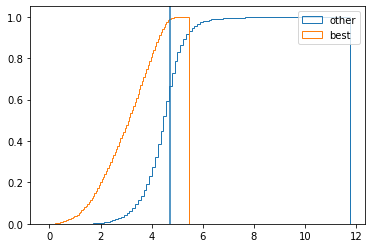

In [24]:
#hist of kd predicted for best register and other registers
kd_other=[]
for x in resdf_train['av']:
    kd_other+=list(x[x!=np.min(x)])
plt.figure()
plt.hist(kd_other,bins=100,histtype='step',density=True,cumulative=1)
plt.hist(resdf_train['pred_logkd'].values,bins=100,histtype='step',density=True,cumulative=1)
plt.axvline(np.log10(50000.))
plt.legend(['other','best'])
plt.show()
#conclusion: pushing other registers towards 50k may not make much difference;
#if do it, use inequality in errorfunc to avoid pushing >50k down

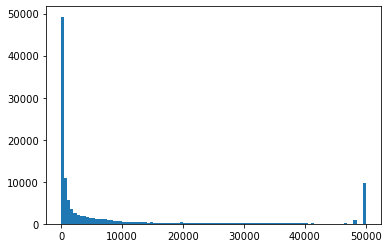

49228


In [114]:
plt.figure()
plt.hist(train['kd'].values,bins=100)
plt.show()
print(np.sum(train['kd']<500))

## AF masks vs min Kd

In [29]:
from tfold.modeling.result_parse_tools import lddt_score

In [30]:
#read tfold modeling results
def _reduce_mhc(x):
    return x.info['species'],x.info['locus'],x.info['allele']
x=[]
for i in range(128):
    x.append(pd.read_pickle(f'/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/processed/batch_{i}/result.pckl'))
tfold_df=pd.concat(x)
tfold_df['pep_lddt']=tfold_df['pep_lddt'].map(lddt_score) #compute average scores
tfold_df['mhc_a']=tfold_df['mhc_a'].map(_reduce_mhc)
tfold_df['mhc_b']=tfold_df['mhc_b'].map(_reduce_mhc)
tfold_df=tfold_df.drop(['mhc_lddt','class'],axis=1)

In [31]:
#load train data and mask
split_n=0
mask_n=7
df=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl')
print(df.columns)
print(len(df))
with open(target_dir+f'/masks/mask_{mask_n}_{split_n}.pckl','rb') as f:
    mask=pickle.load(f)
print(len(mask))
print(mask[0])


Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
114611
114611
[(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]


In [34]:
#compare mask and netmhc
df

,pep,mhc_a,mhc_b,kd
0,APTGMFVAGAKYMVI,"(9606, DPA1, 01:03)","(9606, DPB1, 02:01)",4.397248
1,ATATATSAVGAPTGA,"(9606, DPA1, 01:03)","(9606, DPB1, 02:01)",50000.000000
2,AVKPAAEEVKVIPAG,"(9606, DPA1, 01:03)","(9606, DPB1, 02:01)",35699.947155
3,DVTITAPGDSPNTDG,"(9606, DPA1, 01:03)","(9606, DPB1, 02:01)",50000.000000
5,FVAAAKYMVIQGEPG,"(9606, DPA1, 01:03)","(9606, DPB1, 02:01)",65.182550
...,...,...,...,...
115860,LAELAALNL,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",5142.000000
115861,RRPPLAELAALNLSGSRL,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",417.000000
115862,PPLAELAALNLSGSRL,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",231.000000
115863,FARRPPLAELAALNLSGS,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)",103.000000


In [37]:
#run model
if True:
    model_list=[(25,)]
    t0=time.time()
    df=nn_predict.predict(df,'II',mhc_as_obj=False,
                          model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                          keep_all_predictions=True)[0]
    print('completed in:',time.time()-t0)

making Kd predictions for 114611 pmhcs...


2022-10-13 12:48:20.285460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


completed in: 895.9407806396484


In [50]:
#add mask info
m=pd.Series(mask)
df=df.reset_index(drop=True)
df['mask']=m

In [54]:
bad=df.apply(lambda x: x['seqnn_tails'] not in x['mask'],axis=1)
print(len(df),np.sum(bad))

114611 4282


In [62]:
np.mean((df['seqnn_logkd']-np.log10(df['kd']))**2)**0.5 #training error

0.7751239252601093

In [79]:
a=df['seqnn_logkds_all'].iloc[0]
b=df['mask'].iloc[0]
v=np.zeros(len(a))
for u in b:
    v+=(a['tail']==u)
v

/tmp/ipykernel_24315/2263217324.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  v+=(a['tail']==u)


array([0., 0., 0., 0., 0., 0., 0.])

In [80]:
a=['a','b','c']
b=['1','a','w']
np.isin(a,b)

array([ True, False, False])

In [94]:
i

2114

In [96]:
i=2114
#print(_reduce_to_best_masked_logkd(df.iloc[i]))
x=df.iloc[i]
print(x['seqnn_logkds_all'],x['mask'])

[((0, 6), 3.6203239 ) ((1, 5), 3.29235983) ((2, 4), 3.60180545)
 ((3, 3), 3.21081948) ((4, 2), 3.55704021) ((5, 1), 3.98074746)
 ((6, 0), 1.07933187)] [(-1, 7)]


In [82]:
#seqnn_logkds_all; mask
def _reduce_to_best_masked_logkd(x):
    tails_seqnn=[str(a) for a in x['seqnn_logkds_all']['tail']]
    tails_mask=[str(a) for a in x['mask']]
    return np.min(x['seqnn_logkds_all'][np.isin(tails_seqnn,tails_mask)]['logkd'])
df.apply(_reduce_to_best_masked_logkd,axis=1)
    

ValueError: zero-size array to reduction operation minimum which has no identity

In [61]:
with open(target_dir+'/results_json/run_II_25_0_0_0.json') as f:
    r=f.read()
r

'{"training_time": 3267.6020567417145, "train_corrcoef": 0.4096163406229877, "train_rmse": 1.6200472507530428, "valid_corrcoef": 0.5456121142045417, "valid_rmse": 1.092754065044977, "struct_register_errors": 16, "struct_evaluated": 62, "total_time": 3347.7358734607697}'

In [96]:
#restrict to short masks
mask_len=np.array([len(x) for x in mask])
ind=np.nonzero(mask_len==1)[0]   #for mask 7, only keep len 1 !!!
df=df.iloc[ind].copy()
df=df.reset_index(drop=True)
mask=[mask[i] for i in ind]
print(len(ind))

#add mask info
m=pd.Series([x[0] for x in mask]) #note: assume masks of length 1 !!!
df['mask_tails']=m

#run model
if True:
    model_list=[(25,)]
    t0=time.time()
    df=nn_predict.predict(df,'II',mhc_as_obj=False,
                          model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                          keep_all_predictions=True)[0]
    print('completed in:',time.time()-t0)

Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
114611
114611
[(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]
17816
making Kd predictions for 17816 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


completed in: 172.97575163841248


In [97]:
df_bad=df[df['mask_tails']!=df['seqnn_tails']]
print(len(df),len(df_bad)) #where seqnn min Kd is not in masked register

17816 4282


In [98]:
for x in df_bad.head(25).iterrows():
    x=x[1]
    print(x['pep'],x['mhc_b'],x['mask_tails'],np.log10(x['kd']))
    print(x['seqnn_logkds_all'])
    print()

INEPTAAEIAYGLDR ('9606', 'DQB1', '06:02') (1, 5) 1.066910537424502
[((0, 6), 3.62704921) ((1, 5), 1.29271591) ((2, 4), 4.05349588)
 ((3, 3), 1.11995018) ((4, 2), 3.01040411) ((5, 1), 3.97869182)
 ((6, 0), 3.83646941)]

PQLTKNAGVLTCSLS ('9606', 'DQB1', '06:02') (3, 3) 0.9701728419452362
[((0, 6), 3.98916292) ((1, 5), 3.94909954) ((2, 4), 3.85578251)
 ((3, 3), 2.82274437) ((4, 2), 3.51015425) ((5, 1), 1.98359883)
 ((6, 0), 3.41919184)]

FSQIIKTTLSIKKKE ('9606', 'DRB1', '01:01') (2, 4) 0.922241259065028
[((0, 6), 2.55568624) ((1, 5), 2.20931673) ((2, 4), 2.41242242)
 ((3, 3), 2.6007874 ) ((4, 2), 1.78769433) ((5, 1), 3.65597248)
 ((6, 0), 3.94149733)]

GDKFLANVSTVLTGK ('9606', 'DRB1', '01:01') (4, 2) 0.19097083994622086
[((0, 6), 3.67927241) ((1, 5), 2.93230867) ((2, 4), 3.16955352)
 ((3, 3), 0.84076047) ((4, 2), 0.88534874) ((5, 1), 3.1894486 )
 ((6, 0), 3.94600534)]

GKAFATYTNAKRIVK ('9606', 'DRB1', '01:01') (4, 2) 2.0279485816813088
[((0, 6), 3.60212922) ((1, 5), 3.9016788 ) ((2, 4), 2

In [108]:
d=tfold_df[tfold_df['pep']=='RCYSLYIAENGELTE']
for k in d['pmhc_id'].unique():
    dd=d[d['pmhc_id']==k].iloc[0]
    print(k,dd['mhc_b'],dd['kd'])

1942 ('9606', 'DRB1', '01:01') 1.652757654957955
13972 ('9606', 'DRB1', '04:05') 19.73405697369706
14291 ('9606', 'DRB1', '09:01') 20.74360073361692
34547 ('9606', 'DRB1', '04:01') 141.04814330166923
36014 ('9606', 'DRB1', '04:04') 159.3926931102971
37272 ('9606', 'DRB1', '15:01') 178.21996005956464
42259 ('9606', 'DRB1', '03:01') 282.27340978764465


In [110]:
d[d['pmhc_id']==13972]

,pmhc_id,model_id,tpl_tails,best_score,best_mhc_score,register_identified,af_tails,pep_lddt,pep,mhc_a,mhc_b,kd,n_reg_filtered,af_n_reg,seqnn_logkd
1810,13972,8,"(1, 5)",18,2,False,"(1, 5)",3.138608,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,3.357756
1811,13972,9,"(1, 5)",18,2,False,"(1, 5)",3.282201,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,3.357756
1812,13972,10,"(1, 5)",20,2,True,"(1, 5)",2.476794,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,3.357756
1813,13972,11,"(2, 4)",16,2,False,"(2, 4)",3.380186,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,3.156074
1814,13972,12,"(2, 4)",16,2,True,"(1, 5)",2.285431,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,3.357756
1815,13972,13,"(2, 4)",17,2,True,"(2, 4)",1.751597,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,3.156074
1816,13972,14,"(4, 2)",17,2,True,"(4, 2)",1.433741,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,2.045177
1817,13972,15,"(4, 2)",17,2,True,"(3, 3)",3.134035,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,4.286896
1818,13972,16,"(4, 2)",17,2,False,"(4, 2)",4.163836,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,2.045177
1819,13972,17,"(5, 1)",17,2,True,"(5, 1)",1.959535,RCYSLYIAENGELTE,"(9606, DRA, 01:01)","(9606, DRB1, 04:05)",19.734057,4,5,2.855383


In [105]:
np.log10(1.55)

0.1903316981702915

## masks from AF registers

In [20]:
from tfold.modeling import result_parse_tools

688216
Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'kd', 'n_reg_filtered', 'af_n_reg',
       'seqnn_logkd'],
      dtype='object')
collected in 28.6 s
models per reg:
1     17705
2      3305
3       997
4     20120
5    116086
dtype: int64
reduced to best models in 107.6 s
total pmhcs: 42413
regs per pmhc: 4.0040317827081315
max kd: 285.74751243366114


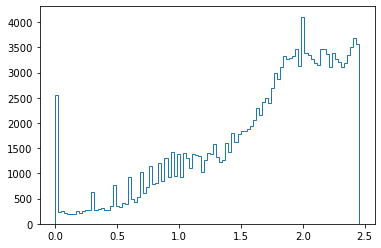

In [21]:
#load results
kd_assays=True #read kd assays or experimental structures  ###CHECK!!!###

if kd_assays:
    af_dir='/scratch/vmikhayl/pmhc_modeling/pmhc_assays_train_II_dataset/processed'
    t0=time.time()
    results_df=[]
    for b in os.listdir(af_dir):
        if 'result.pckl' in os.listdir(af_dir+'/'+b):
            results_df.append(pd.read_pickle(af_dir+f'/{b}/result.pckl'))
    results_df=pd.concat(results_df)
else: #experimental structures
    results_df=pd.read_pickle('/scratch/vmikhayl/pmhc_modeling/discovery_dataset/run_10/result_df.pckl')
    results_df=results_df[results_df['class']=='II'] #restrict to cl II    
print(len(results_df))
print(results_df.columns)
print('collected in {:4.1f} s'.format(time.time()-t0))

######### reduce to n models per register #########
#(for discovery dataset only)#
n=2
def reduce_to_top_models(df,n):
    return df[df['model_id'].isin(np.sort(df['model_id'])[:2])]
if (not kd_assays) and False:#True:
    print(f'REDUCED TO {n} MODELS PER REGISTER')
    results_df=results_df.groupby(['pmhc_id','tpl_tails']).apply(lambda x:reduce_to_top_models(x,1)).reset_index(drop=True)
print('models per reg:')
print(results_df.groupby(['pmhc_id','tpl_tails']).apply(len).value_counts().sort_index())
#############

#add score
results_df['lddt_score']=results_df['pep_lddt'].map(result_parse_tools.lddt_score)

#reduce mhc NUMSEQ to (species,locus,allele)
def reduce_mhc(x):
    y=x.info
    return y['species'],y['locus'],y['allele']
results_df['mhc_a']=results_df['mhc_a'].map(reduce_mhc)
results_df['mhc_b']=results_df['mhc_b'].map(reduce_mhc)

#reduce to best model for each register
t0=time.time()
results_df=result_parse_tools.reduce_to_best(results_df,['pmhc_id','af_tails'],'lddt_score','min').reset_index(drop=True)
print('reduced to best models in {:4.1f} s'.format(time.time()-t0))

#stats
n_pmhcs=len(results_df['pmhc_id'].unique())
n_regs=len(results_df)
print('total pmhcs:',n_pmhcs)
print('regs per pmhc:',n_regs/n_pmhcs)
if kd_assays:
    print('max kd:',results_df['kd'].iloc[-1])
    plt.figure()
    plt.hist(np.log10(results_df['kd']),histtype='step',bins=100)
    plt.show()

In [225]:
x=result_parse_tools.reduce_to_best(results_df,['pmhc_id'],'lddt_score','min').reset_index(drop=True)
print(len(x),x.columns)

62 Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'pep_CA',
       'pep_all', 'mhc_CA', 'mhc_all', 'class', 'cluster_seq', 'pdb_id',
       'date', 'tails', 'netmhc_tails', 'netmhc_kd', 'pep', 'mhc_a', 'mhc_b',
       'exclude_pdbs', 'tails_prefiltered', 'af_n_reg', 'seqnn_logkd',
       'lddt_score'],
      dtype='object')


In [226]:
np.sum(x['tails']!=x['af_tails'])

4

### plot

In [5]:
#ranked scores
scores_sorted=results_df.groupby('pmhc_id')['lddt_score'].apply(np.sort).reset_index()
scores_by_rank={}
score_pairs=[]
for x in scores_sorted['lddt_score']:
    if len(x)>1:
        score_pairs.append(x[:2])
    for i,y in enumerate(x):
        scores_by_rank.setdefault(i+1,[]).append(y)
score_pairs=np.array(score_pairs)
print(score_pairs.shape)
for i,v in scores_by_rank.items():
    print('rank: {}, scores: {}'.format(i,len(v)))

(37608, 2)
rank: 1, scores: 42413
rank: 2, scores: 37608
rank: 3, scores: 30378
rank: 4, scores: 23666
rank: 5, scores: 16972
rank: 6, scores: 10660
rank: 7, scores: 5682
rank: 8, scores: 1772
rank: 9, scores: 403
rank: 10, scores: 171
rank: 11, scores: 67
rank: 12, scores: 23
rank: 13, scores: 7
rank: 14, scores: 1


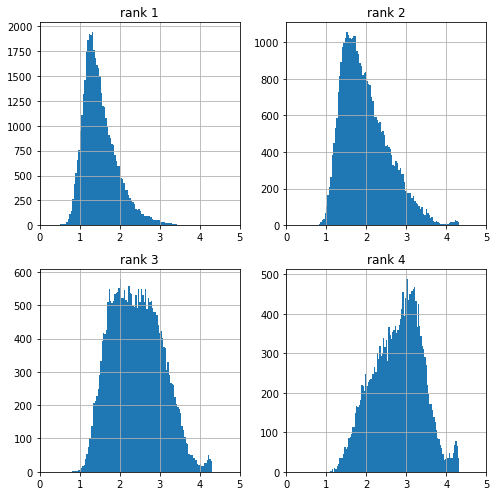

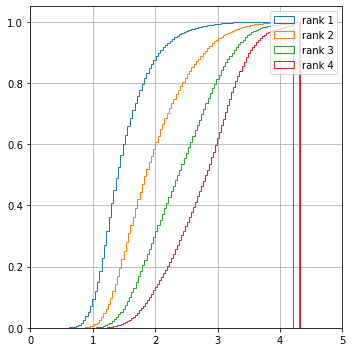

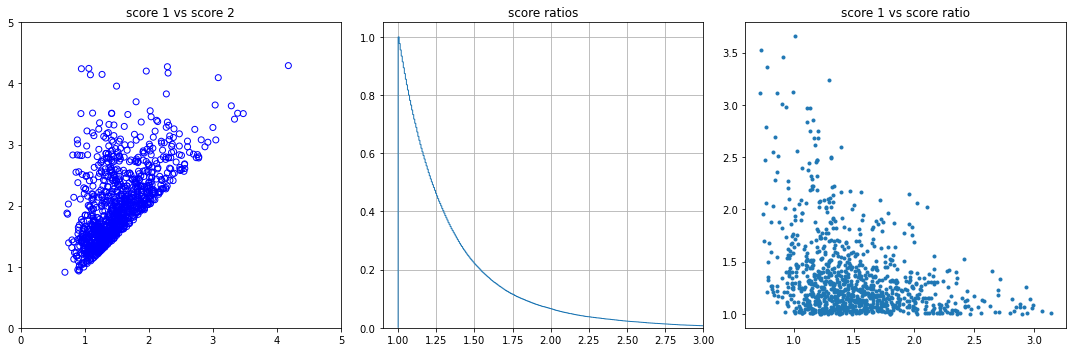

data collected in  34.5 s


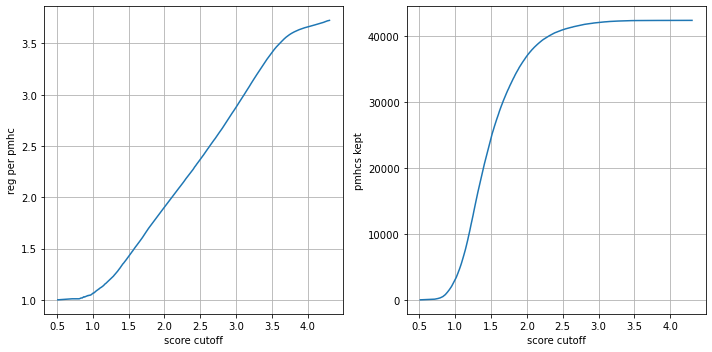

In [6]:
#KEEP!!! MPR=2

#score histograms by rank
plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid()
    plt.hist(scores_by_rank[i+1],bins=100)
    plt.xlim(0,5)    
    plt.title(f'rank {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.grid()
for i in range(4):    
    plt.hist(scores_by_rank[i+1],bins=100,density=True,cumulative=1,histtype='step')
plt.xlim(0,5)
plt.legend([f'rank {i}' for i in range(1,5)])
plt.tight_layout()
plt.show()

#score 1 vs score 2
ind=np.random.permutation(len(score_pairs))[:1000] #subsample
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(*score_pairs[ind].T,facecolor='none',edgecolor='blue') #,marker='.')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('score 1 vs score 2')
plt.subplot(132)
plt.hist(score_pairs[:,1]/score_pairs[:,0],histtype='step',bins=1000,cumulative=-1,density=True)
plt.grid()
plt.xlim(0.9,3.)
plt.title('score ratios')
plt.subplot(133)
x=score_pairs[np.random.permutation(len(score_pairs))[:1000]] #subsample
plt.scatter(x[:,0],x[:,1]/x[:,0],marker='.')#facecolor='none',edgecolor='blue') 
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.title('score 1 vs score ratio')
plt.tight_layout()
plt.show()

#score cutoff vs reg per pmhc and pmhcs kept
t0=time.time()
thresholds=np.sort(results_df['lddt_score'].unique())[1:]
if kd_assays:  #subsample
    thresholds=thresholds[::100]
reg_per_query=[]
pmhcs_kept=[]
for t in thresholds:
    x=results_df[results_df['lddt_score']<t]
    n_pmhcs_c=x['pmhc_id'].nunique()
    pmhcs_kept.append(n_pmhcs_c)
    reg_per_query.append(len(x)/n_pmhcs_c)
print('data collected in {:5.1f} s'.format(time.time()-t0))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(thresholds,reg_per_query)
plt.xlabel('score cutoff')
plt.ylabel('reg per pmhc')
plt.grid()
plt.subplot(122)
plt.plot(thresholds,pmhcs_kept)
plt.xlabel('score cutoff')
plt.ylabel('pmhcs kept')
plt.grid()
plt.tight_layout()
plt.show()

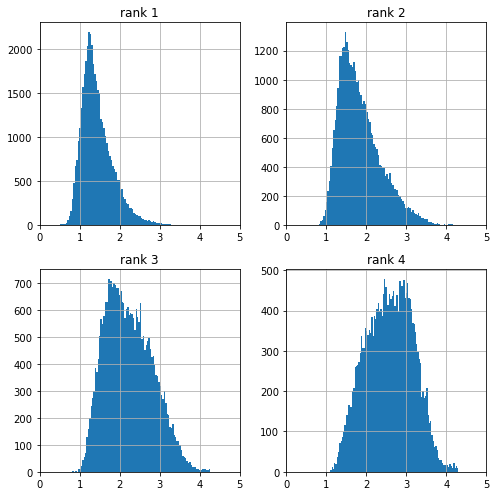

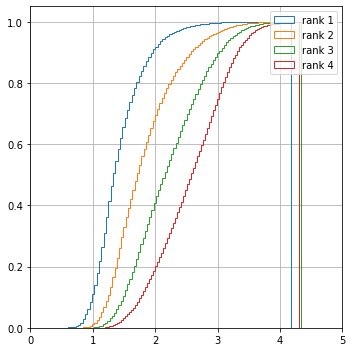

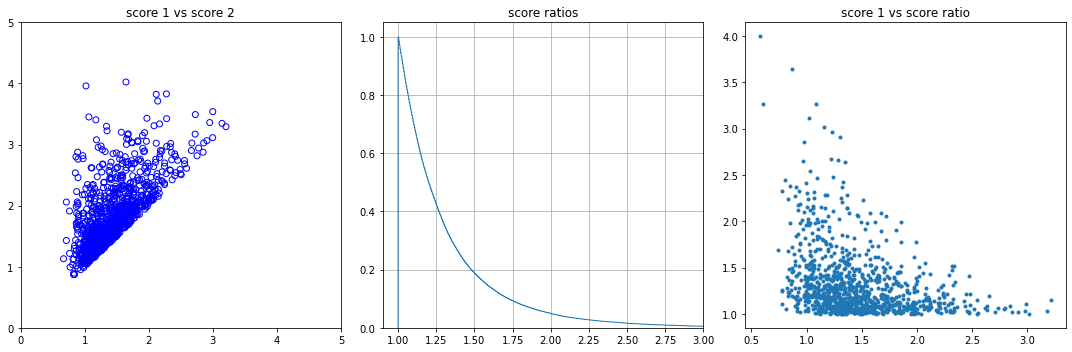

data collected in  42.9 s


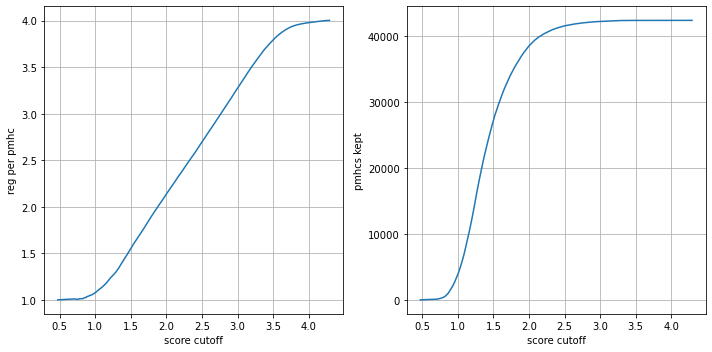

In [6]:
#score histograms by rank
plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid()
    plt.hist(scores_by_rank[i+1],bins=100)
    plt.xlim(0,5)    
    plt.title(f'rank {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.grid()
for i in range(4):    
    plt.hist(scores_by_rank[i+1],bins=100,density=True,cumulative=1,histtype='step')
plt.xlim(0,5)
plt.legend([f'rank {i}' for i in range(1,5)])
plt.tight_layout()
plt.show()

#score 1 vs score 2
ind=np.random.permutation(len(score_pairs))[:1000] #subsample
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(*score_pairs[ind].T,facecolor='none',edgecolor='blue') #,marker='.')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('score 1 vs score 2')
plt.subplot(132)
plt.hist(score_pairs[:,1]/score_pairs[:,0],histtype='step',bins=1000,cumulative=-1,density=True)
plt.grid()
plt.xlim(0.9,3.)
plt.title('score ratios')
plt.subplot(133)
x=score_pairs[np.random.permutation(len(score_pairs))[:1000]] #subsample
plt.scatter(x[:,0],x[:,1]/x[:,0],marker='.')#facecolor='none',edgecolor='blue') 
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.title('score 1 vs score ratio')
plt.tight_layout()
plt.show()

#score cutoff vs reg per pmhc and pmhcs kept
t0=time.time()
thresholds=np.sort(results_df['lddt_score'].unique())[1:]
if kd_assays:  #subsample
    thresholds=thresholds[::100]
reg_per_query=[]
pmhcs_kept=[]
for t in thresholds:
    x=results_df[results_df['lddt_score']<t]
    n_pmhcs_c=x['pmhc_id'].nunique()
    pmhcs_kept.append(n_pmhcs_c)
    reg_per_query.append(len(x)/n_pmhcs_c)
print('data collected in {:5.1f} s'.format(time.time()-t0))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(thresholds,reg_per_query)
plt.xlabel('score cutoff')
plt.ylabel('reg per pmhc')
plt.grid()
plt.subplot(122)
plt.plot(thresholds,pmhcs_kept)
plt.xlabel('score cutoff')
plt.ylabel('pmhcs kept')
plt.grid()
plt.tight_layout()
plt.show()

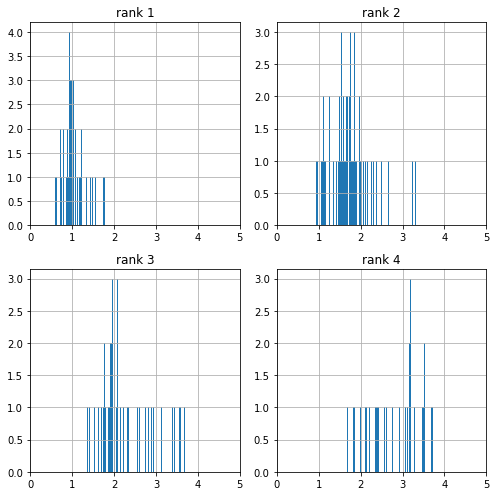

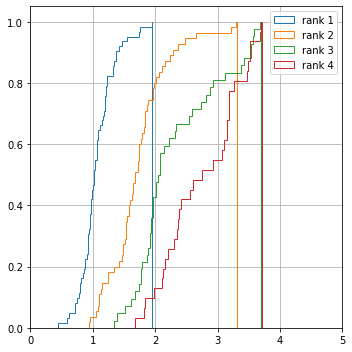

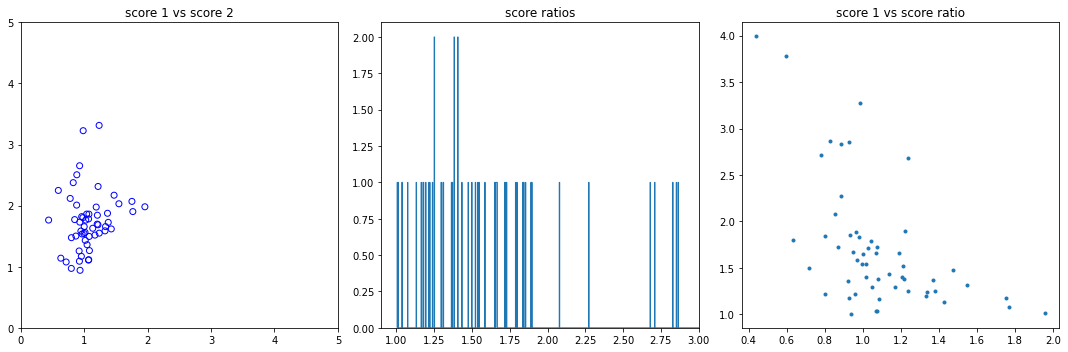

data collected in   0.1 s


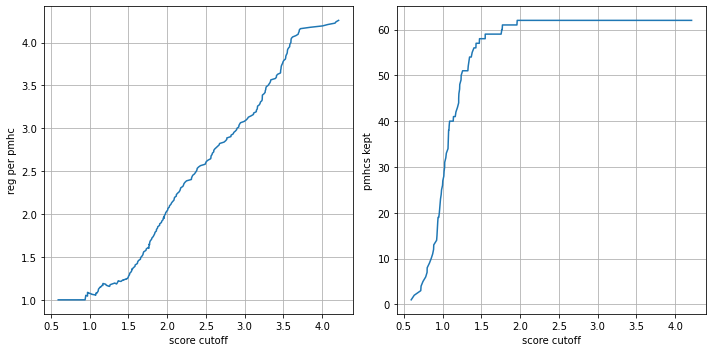

In [74]:
#KEEP: DISCOVERY DATASET PLOTS (all mpr)

#score histograms by rank
plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid()
    plt.hist(scores_by_rank[i+1],bins=100)
    plt.xlim(0,5)    
    plt.title(f'rank {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.grid()
for i in range(4):    
    plt.hist(scores_by_rank[i+1],bins=100,density=True,cumulative=1,histtype='step')
plt.xlim(0,5)
plt.legend([f'rank {i}' for i in range(1,5)])
plt.tight_layout()
plt.show()

#score 1 vs score 2
ind=np.random.permutation(len(score_pairs))[:1000] #subsample
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(*score_pairs[ind].T,facecolor='none',edgecolor='blue') #,marker='.')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('score 1 vs score 2')
plt.subplot(132)
plt.hist(score_pairs[:,1]/score_pairs[:,0],histtype='step',bins=1000)
plt.xlim(0.9,3.)
plt.title('score ratios')
plt.subplot(133)
x=score_pairs[np.random.permutation(len(score_pairs))[:1000]] #subsample
plt.scatter(x[:,0],x[:,1]/x[:,0],marker='.')#facecolor='none',edgecolor='blue') 
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.title('score 1 vs score ratio')
plt.tight_layout()
plt.show()

#score cutoff vs reg per pmhc and pmhcs kept
t0=time.time()
thresholds=np.sort(results_df['lddt_score'].unique())[1:]
if kd_assays:  #subsample
    thresholds=thresholds[::100]
reg_per_query=[]
pmhcs_kept=[]
for t in thresholds:
    x=results_df[results_df['lddt_score']<t]
    n_pmhcs_c=x['pmhc_id'].nunique()
    pmhcs_kept.append(n_pmhcs_c)
    reg_per_query.append(len(x)/n_pmhcs_c)
print('data collected in {:5.1f} s'.format(time.time()-t0))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(thresholds,reg_per_query)
plt.xlabel('score cutoff')
plt.ylabel('reg per pmhc')
plt.grid()
plt.subplot(122)
plt.plot(thresholds,pmhcs_kept)
plt.xlabel('score cutoff')
plt.ylabel('pmhcs kept')
plt.grid()
plt.tight_layout()
plt.show()

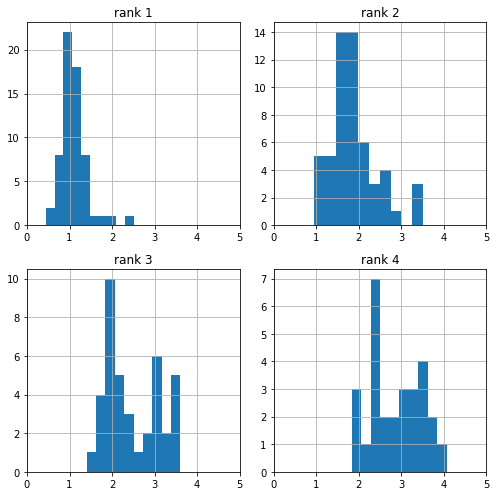

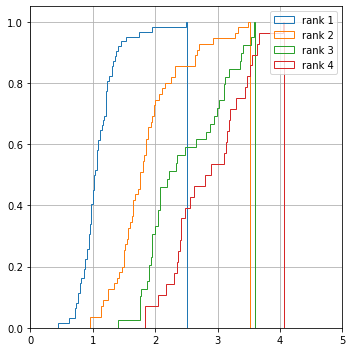

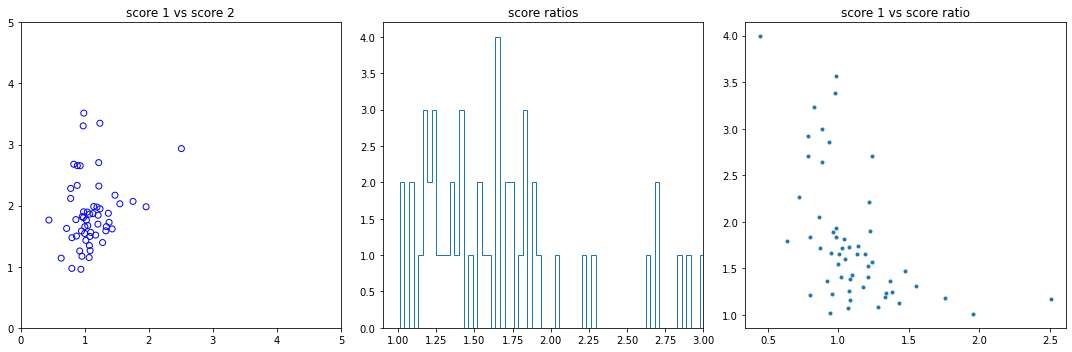

data collected in   0.1 s


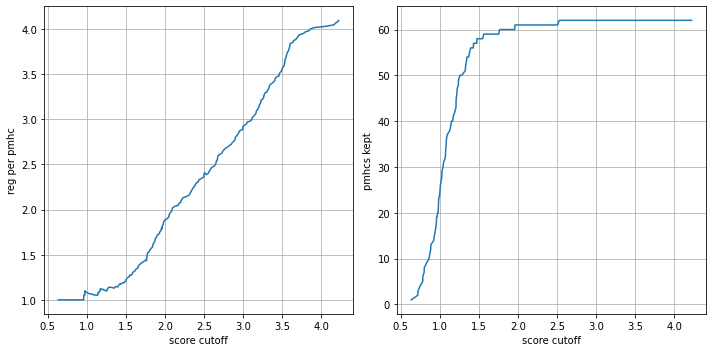

In [103]:
#KEEP: DISCOVERY DATASET PLOTS, REDUCED TO <=2 mpr

#score histograms by rank
plt.figure(figsize=(7,7))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid()
    plt.hist(scores_by_rank[i+1],bins=10)
    plt.xlim(0,5)    
    plt.title(f'rank {i+1}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.grid()
for i in range(4):    
    plt.hist(scores_by_rank[i+1],bins=100,density=True,cumulative=1,histtype='step')
plt.xlim(0,5)
plt.legend([f'rank {i}' for i in range(1,5)])
plt.tight_layout()
plt.show()

#score 1 vs score 2
ind=np.random.permutation(len(score_pairs))[:1000] #subsample
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(*score_pairs[ind].T,facecolor='none',edgecolor='blue') #,marker='.')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('score 1 vs score 2')
plt.subplot(132)
plt.hist(score_pairs[:,1]/score_pairs[:,0],histtype='step',bins=100)
plt.xlim(0.9,3.)
plt.title('score ratios')
plt.subplot(133)
x=score_pairs[np.random.permutation(len(score_pairs))[:1000]] #subsample
plt.scatter(x[:,0],x[:,1]/x[:,0],marker='.')#facecolor='none',edgecolor='blue') 
#plt.xlim(0,5)
#plt.ylim(0,5)
plt.title('score 1 vs score ratio')
plt.tight_layout()
plt.show()

#score cutoff vs reg per pmhc and pmhcs kept
t0=time.time()
thresholds=np.sort(results_df['lddt_score'].unique())[1:]
if kd_assays:  #subsample
    thresholds=thresholds[::100]
reg_per_query=[]
pmhcs_kept=[]
for t in thresholds:
    x=results_df[results_df['lddt_score']<t]
    n_pmhcs_c=x['pmhc_id'].nunique()
    pmhcs_kept.append(n_pmhcs_c)
    reg_per_query.append(len(x)/n_pmhcs_c)
print('data collected in {:5.1f} s'.format(time.time()-t0))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(thresholds,reg_per_query)
plt.xlabel('score cutoff')
plt.ylabel('reg per pmhc')
plt.grid()
plt.subplot(122)
plt.plot(thresholds,pmhcs_kept)
plt.xlabel('score cutoff')
plt.ylabel('pmhcs kept')
plt.grid()
plt.tight_layout()
plt.show()

In [110]:
#decision for mpr=2:
#score<1.4-1.5 is a reasonable cutoff for identified registers;
#keep all regs w. <1.4-1.5, for other pmhcs keep all regs 
#(don't throw out data, especially because prefiltering may have filtered out correct registers sometimes)

#decision for mpr=5:
#(based on discovery and test lddt curves)
#trust regs w. <1.3
#two options:
#1: for <1.3 use best, for others use all
#2: for <1.3 use all that are <1.3, for others use all

### make regmasks

In [60]:
from tfold.nn import nn_utils

In [55]:
#for combining AF masks with seqnn step 1 masks:
#(don't run for pure AF masks)

model_list=[(31,i) for i in range(5)] #step 1 models with AF mask

df=pmhcs_df[pmhcs_df['class']=='II']
df=nn_predict.predict(df,'II',mhc_as_obj=True,
                      model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                      keep_all_predictions=False)
#monitor seqnn regerr
print('regerr:',np.sum(df['tails']!=df['seqnn_tails']))
       
#predict for train, infer seqnn masks
def _reduce_registers_1(x,threshold=1.): #keep registers within x10 of the top  #for mask 1
    return x['tail'][x['logkd']<min(x['logkd'])+threshold]    

t0=time.time()
df1=pd.read_pickle(f'./data/pmhc_assays/train_ii.pckl')
df1=nn_predict.predict(df1,'II',mhc_as_obj=False,
                       model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                       keep_all_predictions=False)
print('inference for {} completed in {}'.format(len(df1),time.time()-t0))
df1['regreduced']=df1['seqnn_logkds_all'].map(_reduce_registers_1)
regdict_seqnn=df1.groupby(['pep','mhc_a','mhc_b'])['regreduced'].apply(lambda z:list(z.values[0])).to_dict()  

print('entries:',len(regdict_seqnn))
print('mean reg per entry:',np.mean([len(x) for x in regdict_seqnn.values()]))

making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


regerr: 12
making Kd predictions for 115836 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


inference for 115836 completed in 1066.4646492004395
entries: 115836
mean reg per entry: 4.593623743913809


In [61]:
##########save mask##########
#for modeled pmhcs, keep all registers with af score < threshold, if any;
#otherwise keep all prefiltered(!!!???) regs

#MPR=2
#mask 3: save all regs with score<1.5; if none, allow all registers (all, not just prefiltered)
#mask 4: top register if score<1.5, all prefiltered registers otherwise (for modeled), all for not modelled
#mask 5: all prefiltered registers for modelled, all for non-modelled (i.e. like mask4 but without using actual AF results)

#MPR=5
#mask 6: all regs with score<1.3; if none, allow all registers (all, not just prefiltered)
#mask 7: top register if score<1.3; all otherwise (not just prefiltered)
#mask 8: same as 6, but do not allow tails out of normal bounds (e.g. (-1,7)) by adding to their score
#mask 9: same as 7, modified as in mask 8

#step 2
#mask 10: AF registers as in mask 9, but fr scores>1.3 use seqnn step 1 filtered registers at threshold x10

#verify results_df
print('results_df:',len(results_df),results_df.columns)

n_mask=10
target_dir='/scratch/vmikhayl/tmp_pmhc_nn'

#mask 3
if n_mask==3: 
    print('MASK 3')
    threshold=1.5 #score threshold
    x=results_df[results_df['lddt_score']<threshold] #reduce by threshold
    regdict=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))    
    
#mask 4
if n_mask==4:
    print('MASK 4')
    regdict=results_df.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()
    threshold=1.5
    x=result_parse_tools.reduce_to_best(results_df,['pmhc_id'],'lddt_score','min')
    x=x[x['lddt_score']<threshold]
    regdict1=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()
    regdict.update(regdict1)
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))
    
#mask 5
if n_mask==5:
    print('MASK 5')
    regdict=results_df.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()    
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))
    
#mask 6
if n_mask==6: 
    print('MASK 6')
    threshold=1.3 #score threshold
    x=results_df[results_df['lddt_score']<threshold] #reduce by threshold
    regdict=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))    
    
#mask 7
if n_mask==7:
    print('MASK 7')    
    threshold=1.3
    x=result_parse_tools.reduce_to_best(results_df,['pmhc_id'],'lddt_score','min')
    x=x[x['lddt_score']<threshold]
    regdict=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()    
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))
    
#mask 8
if n_mask==8: 
    print('MASK 8')
    df=results_df.copy()
    df.loc[df['af_tails'].map(lambda x:x[0]<0 or x[1]<0),'lddt_score']+=5.     
    threshold=1.3 #score threshold
    x=df[df['lddt_score']<threshold] #reduce by threshold
    regdict=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))        
    
#mask 9
if n_mask==9:
    print('MASK 9')    
    df=results_df.copy()
    df.loc[df['af_tails'].map(lambda x:x[0]<0 or x[1]<0),'lddt_score']+=5.    
    threshold=1.3
    x=result_parse_tools.reduce_to_best(df,['pmhc_id'],'lddt_score','min')
    x=x[x['lddt_score']<threshold]
    regdict=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()    
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))  
    
#mask 10
if n_mask==10:
    print('MASK 10')    
    df=results_df.copy()
    df.loc[df['af_tails'].map(lambda x:x[0]<0 or x[1]<0),'lddt_score']+=5.    
    threshold=1.3
    x=result_parse_tools.reduce_to_best(df,['pmhc_id'],'lddt_score','min')
    x=x[x['lddt_score']<threshold]
    regdict_af=x.groupby(['pep','mhc_a','mhc_b'])['af_tails'].apply(lambda z:list(z.values)).to_dict()    
    regdict=regdict_seqnn.copy()
    regdict.update(regdict_af)  #change to AF assignments where available
    print('mean nreg in regdict:',np.mean([len(x) for x in regdict.values()]))  
    
def _reduce_registers(x):
    return regdict.get((x['pep'],x['mhc_a'],x['mhc_b']),nn_utils.generate_registers_II(len(x['pep'])))    
    
if True: #SAVE
    t0=time.time()
    for split_n in [0,1,2,3,4]:
        train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl')    
        regs_to_save=train.apply(_reduce_registers,axis=1)                        
        print('mean nreg reduced:',regs_to_save.map(len).mean())    
        #save mask    
        with open(target_dir+f'/masks/mask_{n_mask}_{split_n}.pckl','wb') as f:
            pickle.dump(regs_to_save.values,f)   
    print(f'all done in {time.time()-t0}')
    
#mask 8
#mean nreg in regdict: 1.3075354170111901
#mean nreg reduced: 6.361588329217963 (split 0)

#mask 9
#mean nreg in regdict: 1.0
#mean nreg reduced: 6.314350280514087

#mask 10
#mean nreg in regdict: 4.345911461031113
#mean nreg reduced: 4.356108924972298

results_df: 169823 Index(['pmhc_id', 'model_id', 'tpl_tails', 'best_score', 'best_mhc_score',
       'register_identified', 'af_tails', 'pep_lddt', 'mhc_lddt', 'class',
       'pep', 'mhc_a', 'mhc_b', 'kd', 'n_reg_filtered', 'af_n_reg',
       'seqnn_logkd', 'lddt_score'],
      dtype='object')
MASK 10
mean nreg in regdict: 4.345911461031113
mean nreg reduced: 4.356108924972298
mean nreg reduced: 4.34440374727055
mean nreg reduced: 4.344816416577662
mean nreg reduced: 4.350199977344615
mean nreg reduced: 4.373935758513932
all done in 13.447911262512207


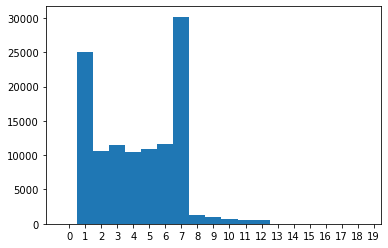

In [62]:
#look at register stats
n_mask=10
split_n=0
with open(target_dir+f'/masks/mask_{n_mask}_{split_n}.pckl','rb') as f:
    regs=pickle.load(f)
l_regs=[len(x) for x in regs]
plt.figure()
plt.hist(l_regs,bins=np.arange(20)-0.5)
plt.xticks(np.arange(20),np.arange(20))
plt.show()

In [44]:
regs

array([list([(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]),
       list([(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]),
       list([(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1), (6, 0)]),
       ..., list([(2, 5), (7, 0)]), list([(6, 3)]),
       list([(0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (7, 0)])],
      dtype=object)

### debug masks

In [69]:
n_mask=4
split_n=0

train=pd.read_pickle(f'./data/pmhc_assays/train_clustered/split_ii/train_{split_n}.pckl')    
print(len(train),train.columns)
with open(target_dir+f'/masks/mask_{n_mask}_{split_n}.pckl','rb') as f:
    mask=pickle.load(f) 
print(len(mask))
print(mask[0])

114611 Index(['pep', 'mhc_a', 'mhc_b', 'kd'], dtype='object')
114611
[(5, 1), (6, 0)]


In [70]:
def map_mhc(x):
    y=x.info
    return y['species'],y['locus'],y['allele']
x=pmhcs_df[pmhcs_df['class']=='II'].copy()
x['mhc_a']=x['mhc_a'].map(map_mhc)
x['mhc_b']=x['mhc_b'].map(map_mhc)
print(len(x),x.columns)

62 Index(['id', 'date', 'pmhc_id', 'class', 'tails', 'netmhc_tails', 'netmhc_kd',
       'pep', 'mhc_a', 'mhc_b'],
      dtype='object')


In [75]:
#identify exp structures for which exact match in kd training set is present

#pep,mhc_a,mhc_b tuples
k_train=train[['pep','mhc_a','mhc_b']].apply(lambda x:tuple(x),axis=1)
k_struct=x[['pep','mhc_a','mhc_b']].apply(lambda x:tuple(x),axis=1)

struct_subset=x[k_struct.isin(k_train)]
print(len(struct_subset))
print(struct_subset['id'].values)
struct_subset

6
[ 26  88 147 176 341 374]


,id,date,pmhc_id,class,tails,netmhc_tails,netmhc_kd,pep,mhc_a,mhc_b
22,26,1994-02-15,26,II,"(2, 2)","(2, 2)",40.285120,PKYVKQNTLKLAT,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)"
79,88,2001-12-11,95,II,"(3, 3)","(3, 3)",17.674657,GELIGTLNAAKVPAD,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)"
131,147,1997-07-28,177,II,"(3, 2)","(3, 2)",48.707685,GSDARFLRGYHLYA,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)"
160,176,2018-03-15,225,II,"(2, 2)","(2, 2)",23.585714,RFYKTLRAEQASQ,"(9606, DRA, 01:01)","(9606, DRB1, 01:01)"
310,341,2016-04-28,553,II,"(5, 1)","(4, 2)",38.359454,TSKGLFRAAVPSGAS,"(9606, DRA, 01:01)","(9606, DRB1, 04:01)"
342,374,2018-03-13,625,II,"(2, 2)","(1, 3)",179.796801,RFYKTLRAEQASQ,"(9606, DRA, 01:01)","(9606, DRB1, 11:01)"


In [76]:
import tfold.nn.nn_predict as nn_predict
import tfold.config
importlib.reload(tfold.config)
importlib.reload(nn_predict)
params_dir=target_dir+'/inputs'
weights_dir=target_dir+'/weights'

In [77]:
#all models evaluated on cl II experimental structures

model_list=[(13,i) for i in range(5)]  #mask 4
df=pmhcs_df[pmhcs_df['class']=='II'].copy()
df=nn_predict.predict(df,'II',mhc_as_obj=True,
                      model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                      keep_all_predictions=False)
y=df[df['seqnn_tails']!=df['tails']]
print(len(y))
print(y['id'].values)

model_list=[(13,i+5) for i in range(5)]  #mask 5
df1=pmhcs_df[pmhcs_df['class']=='II'].copy()
df1=nn_predict.predict(df1,'II',mhc_as_obj=True,
                      model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                      keep_all_predictions=False)
y1=df1[df1['seqnn_tails']!=df1['tails']]
print(len(y1))
print(y1['id'].values)

#regerr: 10 for mask 4, 16 for mask 5: improvement as expected! Why the hell is valid error so high then??


#ids that have exact pep-mhc_a-mhc_b match in kd training set 0:
#[ 26  88 147 176 341 374]
#note: regerr quite different between mask 4 and mask 5 seqnns; 
#only one of 16 regerr in mask 5 are directly restricted by mask 4 (id 374)

making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10
[ 67  72 112 130 171 189 204 275 421 465]
making Kd predictions for 62 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16
[ 63  72 112 114 130 171 189 275 296 353 371 374 421 465 468 485]


In [68]:
y=df[df['seqnn_tails']!=df['tails']]
print(len(y)) #regerr only 10 now! how so, if valid error is so huge???
y

10


,id,date,pmhc_id,class,tails,netmhc_tails,netmhc_kd,pep,mhc_a,mhc_b,seqnn_logkds_all,seqnn_logkd,seqnn_tails
61,67,2001-09-26,72,II,"(3, 10)","(8, 5)",2600.637544,HSRGGASQYRPSQRHGTGSGSG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 13), 5.228733539581299], [(1, 12), 4.047...",3.819273,"(8, 5)"
66,72,2014-02-15,77,II,"(1, 3)","(1, 3)",2352.780774,APQPELPYPQPGS,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 4), 7.747509002685547], [(1, 3), 5.36583...",4.295105,"(3, 1)"
98,112,1996-04-05,133,II,"(8, 3)","(8, 3)",364.072351,RDSRGKKVITAFNEGLKGGG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 11), 6.236532211303711], [(1, 10), 6.520...",3.529026,"(7, 4)"
115,130,1999-10-28,156,II,"(3, 4)","(3, 4)",14044.412723,GNSHRGAIEWEGIESG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 7), 5.290065765380859], [(1, 6), 5.39625...",4.587224,"(2, 5)"
155,171,2004-02-05,216,II,"(1, 3)","(3, 1)",1668.128107,QPFPQPELPYPGS,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 4), 6.193025588989258], [(1, 3), 7.05866...",4.471870,"(3, 1)"
173,189,2012-07-28,248,II,"(-1, 2)","(1, 0)",22271.296069,GKQNCLKLAT,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 1), 4.981915473937988], [(1, 0), 4.42011...",4.420111,"(1, 0)"
187,204,2004-07-21,277,II,"(2, 1)","(2, 1)",4686.509096,SRGGASQYRPSQ,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 3), 3.797809362411499], [(1, 2), 4.34506...",3.797809,"(0, 3)"
253,275,2017-11-11,416,II,"(4, 3)","(5, 2)",4369.087483,HLVERLYLVCGEEGAG,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 7), 5.056073188781738], [(1, 6), 5.10923...",3.555933,"(5, 2)"
383,421,2010-07-29,755,II,"(2, 3)","(2, 3)",12307.545516,FSWGAEGQRPGFGS,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 5), 5.485454559326172], [(1, 4), 5.67872...",4.251367,"(4, 1)"
425,465,1997-10-16,871,II,"(2, 1)","(2, 1)",1523.962234,AYMRADAAAGGA,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,<tfold.utils.seq_tools.NUMSEQ object at 0x7f16...,"[[(0, 3), 4.014401435852051], [(1, 2), 2.65318...",2.653186,"(1, 2)"


In [65]:
#run on train assays for which single reg was in regmask

#train assays with one reg in mask
train_reduced=train[[len(a)==1 for a in mask]].copy()
mask_reduced=mask[[len(a)==1 for a in mask]]
train_reduced['tails_mask']=[a[0] for a in mask_reduced]
print(len(train_reduced),len(mask_reduced))

#run seqnn on them (mask 4)
model_list=[(13,0)] #only 0 since others have different training set
train_reduced=nn_predict.predict(train_reduced,'II',mhc_as_obj=False,
                                 model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                                 keep_all_predictions=False)

print(np.sum(train_reduced['seqnn_tails']!=train_reduced['tails_mask']),len(train_reduced))
#for 6893 of 26188 (26%), seqnn tail is different from tail in mask

26188 26188
making Kd predictions for 26188 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6893 26188


In [66]:
#do the same with mask 5
model_list=[(13,5)] #only 5 since others have different training set
train_reduced1=nn_predict.predict(train_reduced,'II',mhc_as_obj=False,
                                 model_list=model_list,params_dir=params_dir,weights_dir=weights_dir,
                                 keep_all_predictions=False)

print(np.sum(train_reduced1['seqnn_tails']!=train_reduced1['tails_mask']),len(train_reduced1))
#for 10183 of 26188 (38%), seqnn tail is different from tail in mask

making Kd predictions for 26188 pmhcs...


/home/vmikhayl/anaconda3/envs/bio-p310/lib/python3.10/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['regmask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10183 26188


## evaluate energy model with MJ and contact matrices as weights

In [108]:
k=32,0,0,0
params=params_all[k]
model_func=getattr(tfold_models,params['model'])        
model=model_func(params)
weight_path=target_dir+f'/weights/run_II_'+'_'.join([f'{kk}' for kk in k[:4]])
model.load_weights(weight_path)

In [109]:
#get contact matrix
n_pep=params['n_pep']
n_mhc=params['n_mhc']
with open('./data/obj/pmhc_contacts_av.pckl','rb') as f:
    contacts=pickle.load(f) #sorted
    mhc_resnames=contacts['II']['res'][:n_mhc].values
with open('/data/vmikhayl/tfold/data/experimental_structures/processed_updated/contact_maps_pep-mhc.pckl','rb') as f:
    d=pickle.load(f)
pair_contacts=d['pair_contacts'] #dict (pep,mhc):[contacts]
contact_matrix=np.zeros([n_pep,n_mhc])
for i in range(n_pep):
    for j in range(n_mhc):
        m=int(mhc_resnames[j][:-1])
        if m<1000:
            letter='M'
        else:
            letter='N'        
        contact_matrix[i,j]=np.mean(pair_contacts['II']['P{:4d} '.format(i+1),letter+mhc_resnames[j]])   
contact_matrix=contact_matrix/np.std(contact_matrix)

In [110]:
#MJ matrix (borrowed from George, Kessler, Levine, "Effects of Thymic Selection..."
mj_aa='C M F I L V W Y A G T S N Q D E H R K P'
mj='''
C 5.44 4.99 5.80 5.50 5.83 4.96 4.95 4.16 3.57 3.16 3.11 2.86 2.59 2.85 2.41 2.27 3.60 2.57 1.95 3.07
M 4.99 5.46 6.56 6.02 6.41 5.32 5.55 4.91 3.94 3.39 3.51 3.03 2.95 3.30 2.57 2.89 3.98 3.12 2.48 3.45
F 5.80 6.56 7.26 6.84 7.28 6.29 6.16 5.66 4.81 4.13 4.28 4.02 3.75 4.10 3.48 3.56 4.77 3.98 3.36 4.25
I 5.50 6.02 6.84 6.54 7.04 6.05 5.78 5.25 4.58 3.78 4.03 3.52 3.24 3.67 3.17 3.27 4.14 3.63 3.01 3.76
L 5.83 6.41 7.28 7.04 7.37 6.48 6.14 5.67 4.91 4.16 4.34 3.92 3.74 4.04 3.40 3.59 4.54 4.03 3.37 4.20
V 4.96 5.32 6.29 6.05 6.48 5.52 5.18 4.62 4.04 3.38 3.46 3.05 2.83 3.07 2.48 2.67 3.58 3.07 2.49 3.32
W 4.95 5.55 6.16 5.78 6.14 5.18 5.06 4.66 3.82 3.42 3.22 2.99 3.07 3.11 2.84 2.99 3.98 3.41 2.69 3.73
Y 4.16 4.91 5.66 5.25 5.67 4.62 4.66 4.07 3.36 3.01 3.01 2.78 2.76 2.97 2.76 2.79 3.52 3.16 2.60 3.19
A 3.57 3.94 4.81 4.58 4.91 4.04 3.82 3.36 2.72 2.31 2.32 2.01 1.84 1.89 1.70 1.51 2.41 1.83 1.31 2.03
G 3.16 3.39 4.13 3.78 4.16 3.38 3.42 3.01 2.31 2.24 2.08 1.82 1.74 1.66 1.59 1.22 2.15 1.72 1.15 1.87
T 3.11 3.51 4.28 4.03 4.34 3.46 3.22 3.01 2.32 2.08 2.12 1.96 1.88 1.90 1.80 1.74 2.42 1.90 1.31 1.90
S 2.86 3.03 4.02 3.52 3.92 3.05 2.99 2.78 2.01 1.82 1.96 1.67 1.58 1.49 1.63 1.48 2.11 1.62 1.05 1.57
N 2.59 2.95 3.75 3.24 3.74 2.83 3.07 2.76 1.84 1.74 1.88 1.58 1.68 1.71 1.68 1.51 2.08 1.64 1.21 1.53
Q 2.85 3.30 4.10 3.67 4.04 3.07 3.11 2.97 1.89 1.66 1.90 1.49 1.71 1.54 1.46 1.42 1.98 1.80 1.29 1.73
D 2.41 2.57 3.48 3.17 3.40 2.48 2.84 2.76 1.70 1.59 1.80 1.63 1.68 1.46 1.21 1.02 2.32 2.29 1.68 1.33
E 2.27 2.89 3.56 3.27 3.59 2.67 2.99 2.79 1.51 1.22 1.74 1.48 1.51 1.42 1.02 0.91 2.15 2.27 1.80 1.26
H 3.60 3.98 4.77 4.14 4.54 3.58 3.98 3.52 2.41 2.15 2.42 2.11 2.08 1.98 2.32 2.15 3.05 2.16 1.35 2.25
R 2.57 3.12 3.98 3.63 4.03 3.07 3.41 3.16 1.83 1.72 1.90 1.62 1.64 1.80 2.29 2.27 2.16 1.55 0.59 1.70
K 1.95 2.48 3.36 3.01 3.37 2.49 2.69 2.60 1.31 1.15 1.31 1.05 1.21 1.29 1.68 1.80 1.35 0.59 0.12 0.97
P 3.07 3.45 4.25 3.76 4.20 3.32 3.73 3.19 2.03 1.87 1.90 1.57 1.53 1.73 1.33 1.26 2.25 1.70 0.97 1.75
'''
mj_aa=mj_aa.split()
mj=np.array([x.split()[1:] for x in mj.split('\n')[1:-1]]).astype(float)
from tfold.nn.pipeline import aa_ext
ind_aa=[mj_aa.index(a) for a in aa_ext[:-1]]
mj=mj[ind_aa,:]
mj=mj[:,ind_aa]
mj_av=np.mean(mj)  #mean energy
mj_ext=np.zeros([21,21])
mj_ext[:-1,:-1]=mj
mj_ext[-1,:]=mj_av #set gap energies to mean
mj_ext[:,-1]=mj_av #set gap energies to mean

train corr coef: -0.30100287775088136
regerrors: 52


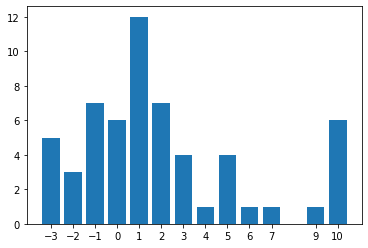

In [117]:
#evaluate

w_aa=mj_ext.copy()
w_rr=contact_matrix.copy()

#scramble w_aa
#w_aa=np.random.permutation(w_aa.reshape(21*21)).reshape((21,21))
#w_aa=w_aa[np.random.permutation(21),:]
#w_aa=w_aa[:,np.random.permutation(21)]
#w_aa_mean=np.mean(w_aa)
#w_aa_std=np.std(w_aa)
#w_aa=w_aa_mean+w_aa_std*np.random.rand(21*21).reshape([21,21])
#scramble w_rr
#w_rr=np.random.permutation(w_rr)
w_rr_mean=np.mean(w_rr)
w_rr_std=np.std(w_rr)
w_rr=w_rr_mean+w_rr_std*np.random.rand(n_pep*n_mhc).reshape([n_pep,n_mhc])

model.weights[0].assign(w_aa)

w_rr=w_rr.reshape(n_pep*n_mhc)[:,np.newaxis]
#w_rr=np.random.permutation(w_rr) #w_rr completely shuffled
model.weights[1].assign(w_rr)

x=model(inputs_train).numpy()
x_best=np.max(x,axis=1) #because high MJ score means strong interaction, see e.g. C-C or hydrophobic pairs
print('train corr coef:',np.corrcoef(np.log10(resdf_train['kd']).values,x_best)[0,1])
x=model(inputs_struct).numpy()
regs=[]
for i in range(len(x)):
    regs.append(np.argmin(x[i][:inputs_struct['n_reg'][i]]))
regs=np.array(regs)
print('regerrors:',np.sum(regs!=resdf_struct['tails'].values))
shifts=regs-resdf_struct['tails'].values
shifts_u=np.sort(np.unique(shifts))
plt.figure()
plt.bar(shifts_u,[np.sum(shifts==a) for a in shifts_u]) # for a in np.,histtype='step',bins=50)
plt.xticks(shifts_u)
plt.show()

#train corrcoef, struct regerr
#trained model:       0.622, 26 (switched max to min!)
#MJ, contact matrix: -0.260, 55
#MJ shuffled:        -0.025, 48
#MJ[ind,:]           -0.161, 52
#MJ[:,ind]           -0.066, 53
#cont shuffled:      -0.272, 55
#aa random w mean and variance from MJ: 0.033, 49
#cont random w mean and variance from cont: -0.301, 52

#conclusion: MJ matters, contact matrix doesn't
#but MJ (partly) works even after permuting one index (pep; mhc?)
#=> MJ scores for pep and for mhc likely contribute; probably hydrophobicity score
#random cont works the best => way of combining independent pep and mhc scores 

In [133]:
#simple MJ pep and mhc score model
mj_reduced=np.sum(mj_ext,axis=1)
mj_reduced=(mj_reduced-np.mean(mj_reduced))/np.std(mj_reduced)
scores_pep=np.max(np.sum(np.dot(inputs_train['pep'],mj_reduced),axis=1),axis=1)
scores_mhc=np.sum(np.dot(inputs_train['mhc'],mj_reduced),axis=1)
print('pep score corr:',np.corrcoef(np.log10(resdf_train['kd']).values,scores_pep)[0,1])
print('mhc score corr:',np.corrcoef(np.log10(resdf_train['kd']).values,scores_mhc)[0,1])
#pep -0.238, mhc -0.117: as expected! explains untrained energy model performance irresp. of contact matrix

#combine pep and mhc scores
from sklearn.linear_model import LinearRegression
x=np.array([scores_pep,scores_mhc]).T
y=np.log10(resdf_train['kd']).values
reg=LinearRegression().fit(x, y)
#predict on train
print('train')
x1=reg.predict(x)
print('corrcoef:',np.corrcoef(x1,y)[0,1])
print('rmse:',(np.mean((x1-y)**2))**0.5)
#predict on valid
print('valid')
scores_pep=np.max(np.sum(np.dot(inputs_valid['pep'],mj_reduced),axis=1),axis=1)
scores_mhc=np.sum(np.dot(inputs_valid['mhc'],mj_reduced),axis=1)
x=np.array([scores_pep,scores_mhc]).T
y=np.log10(resdf_valid['kd']).values
x1=reg.predict(x)
print('corrcoef:',np.corrcoef(x1,y)[0,1])
print('rmse:',(np.mean((x1-y)**2))**0.5)

#corrcoef, rmse
#train 0.263, 1.181
#valid 0.248, 1.374

pep score corr: -0.23762279511392248
mhc score corr: -0.11678213200351784
train
corrcoef: 0.26275156081948464
rmse: 1.1806177324395406
valid
corrcoef: 0.24793001049801336
rmse: 1.3741907275075431


## continue

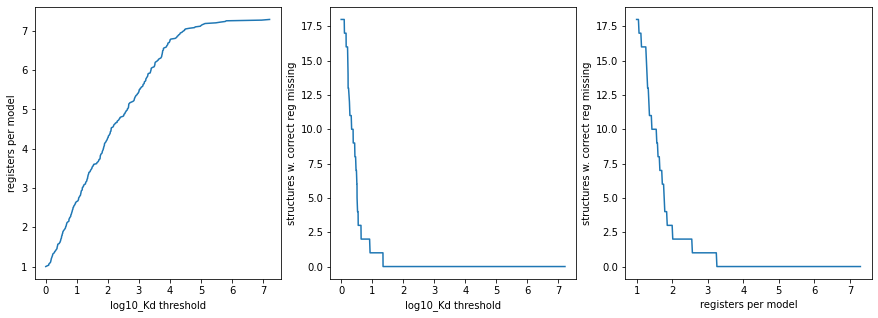

In [80]:
kd_tuples=(resdf_struct['av']-resdf_struct['pred_logkd']).values
kd_list=np.sort(np.unique([x for row in kd_tuples for x in row]))
error_summary=[]
for threshold in kd_list:
    registers_kept=0
    errors_kept=0
    for x in zip(kd_tuples,resdf_struct['tails']):        
        registers_kept+=np.sum(x[0]<=threshold)
        errors_kept+=int(x[0][x[1]]>threshold)
    error_summary.append([threshold,registers_kept/len(kd_tuples),errors_kept]) #threshold, reg/str, errors
error_summary=np.array(error_summary)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(error_summary[:,0],error_summary[:,1])
plt.xlabel('log10_Kd threshold')
plt.ylabel('registers per model')
plt.subplot(132)
plt.plot(error_summary[:,0],error_summary[:,2])
plt.xlabel('log10_Kd threshold')
plt.ylabel('structures w. correct reg missing')
plt.subplot(133)
plt.plot(error_summary[:,1],error_summary[:,2])
plt.xlabel('registers per model')
plt.ylabel('structures w. correct reg missing')
plt.show()

In [260]:
#save registers
threshold=2.
n_errors=0
regs_to_save={}
for i,x in enumerate(kd_tuples):
    y=np.nonzero(x<=threshold)[0] #regs to save
    c_id=resdf_struct['id'].iloc[i]
    regs_to_save[c_id]=y
    if resdf_struct['tails'].iloc[i] not in y:
        n_errors+=1
        print('error tid:',resdf_struct['id'].iloc[i])
print('correct reg missing for:',n_errors)
print('average reg per pmhs:',np.average([len(x) for x in regs_to_save.values()]))
with open('./tmp/seqnn_regs_ii.pckl','wb') as f:
    pickle.dump(regs_to_save,f)

error tid: 368
error tid: 393
correct reg missing for: 2
average reg per pmhs: 4.775862068965517


In [189]:
#compare AF and seq_nn reg errors 
df=df_modeled_ii
af_wrong_ids=set(list(df[df['pdbnum']!=df['pdbnum_model']]['tid'].values))
seqnn_wrong_ids=set(list(resdf_struct[resdf_struct['pred_reg']!=resdf_struct['tails']]['id']))
print(f'af mistakes: {len(af_wrong_ids)}, seqnn mistakes: {len(seqnn_wrong_ids)}')
intersect_set=af_wrong_ids&seqnn_wrong_ids
print(f'intersection: {len(intersect_set)}')                   
print(df[df['tid'].isin(intersect_set)])

af mistakes: 5, seqnn mistakes: 26
intersection: 2
     tid                pepseq                   mhc  cl  cid  \
tid                                                             
809  809  GWISLWKGFSFGSGGSIEGR  DRA*01:01 DRB1*01:01  II   16   
850  850  SRLGLWSRMDQLAKELTAEL          IAA*d IAB*g7  II   31   

                                                pdbnum  \
tid                                                      
809  09,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,1...   
850  09,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,1...   

                                       pdbnum_template  match  pep_s  mhc_s  \
tid                                                                           
809  06,07,08,09,1,2,3,4,5,6,7,8,9,10,11,12,13,14,1...  False     16      0   
850  03,04,05,06,07,08,09,1,2,3,4,5,6,7,8,9,10,11,1...  False     23      0   

      pep_lddt   mhc_lddt     pep_CA    pep_all    mhc_CA   mhc_all  \
tid                                                                

mean shift for predicted: 0.29, simulated: 0.78


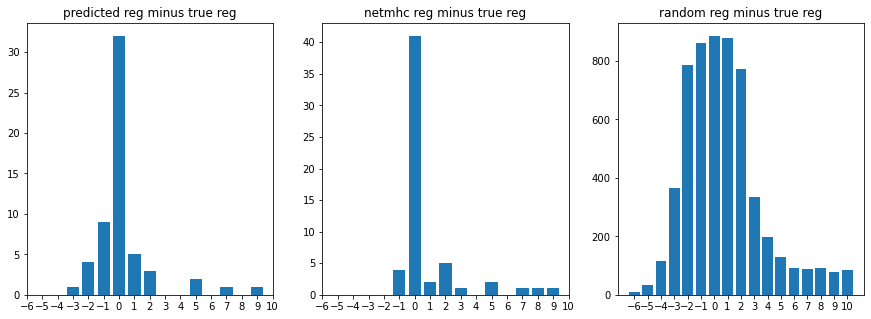

In [222]:
#plot distrib of register shifts

x=(resdf_struct['pred_reg']-resdf_struct['tails']).values
pos=np.sort(np.unique(x))
x1=(resdf_struct['netmhc_tails']-resdf_struct['tails']).values
pos1=np.sort(np.unique(x1))
#simulate random registers
random_regs=[]
N=100
for i in range(N):
    random_regs+=list(np.random.randint(resdf_struct['pep'].map(len).values-8)-resdf_struct['tails']) #possible shift 0..l-9
x2=np.array(random_regs)
pos2=np.sort(np.unique(x2))

print('mean shift for predicted: {:4.2f}, simulated: {:4.2f}'.format(np.average(x),np.average(x1)))
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.bar(pos,[np.sum(x==a) for a in pos]) # for a in np.,histtype='step',bins=50)
plt.xticks(pos2)
plt.title('predicted reg minus true reg')
plt.subplot(132)
plt.bar(pos1,[np.sum(x1==a) for a in pos1]) # for a in np.,histtype='step',bins=50)
plt.xticks(pos2)
plt.title('netmhc reg minus true reg')
plt.subplot(133)
plt.bar(pos2,[np.sum(x2==a) for a in pos2]) # for a in np.,histtype='step',bins=50)
plt.xticks(pos2)
plt.title('random reg minus true reg')
plt.show()

In [232]:
#min kd vs 1/sum(1/kd) examples
#len 15: 7 reg
ks=[1000.]+[25000.]*6
ks=np.array(ks)
np.sum(ks**(-1))**(-1)

806.4516129032254

## weights in energy model

In [279]:
#look at weights in energy model
#k=31,0,0 #r,m,s
k=34,2,0 #r,m,s
symmetrize=False

import tfold.nn.models
import importlib
importlib.reload(tfold.nn.models)
tfold_models=tfold.nn.models
params_dir=target_dir+'/inputs'
params_all={}
for filename in os.listdir(params_dir): 
    run_n=int(filename.split('.')[0].split('_')[1])
    with open(params_dir+'/'+filename) as f:
        d=json.load(f) 
    d={(run_n,x['model_n'],x['split_n'],x['copy_n']):x for x in d}
    params_all.update(d)
params=params_all[k[0],k[1],k[2],0]
model_func=getattr(tfold_models,params['model'])        
model=model_func(params)
w_aa=[]
w_rr=[]
for k1 in params_all:
    if k1[:3]==k:
        weight_path=target_dir+f'/weights/run_II_'+'_'.join([f'{kk}' for kk in k1[:4]])
        model.load_weights(weight_path)
        w_aa.append(model.weights[0].numpy()) #weight 0 is aa kernel
        w_rr.append(model.weights[1].numpy()) #weight 1 is rr kernel (assuming no aa bias)
w_aa=np.stack(w_aa)        #-1,21,21
w_rr=np.stack(w_rr)
w_rr=w_rr[:,:,0] #drop dim #-1,n_pep*n_mhc
print('w_aa correlation between copies:')
print(np.corrcoef(w_aa.reshape([-1,21*21])))
print('w_rr correlation between copies:')
print(np.corrcoef(w_rr))
#correlation of w_rr between runs is low when l1 is high!

w_aa correlation between copies:
[[1.         0.77658341 0.95543379 0.79749923 0.7474909 ]
 [0.77658341 1.         0.82076862 0.82695599 0.77679164]
 [0.95543379 0.82076862 1.         0.77910932 0.74501164]
 [0.79749923 0.82695599 0.77910932 1.         0.78969473]
 [0.7474909  0.77679164 0.74501164 0.78969473 1.        ]]
w_rr correlation between copies:
[[1.         0.83033999 0.97342368 0.79810013 0.84363588]
 [0.83033999 1.         0.84754015 0.89730716 0.84157827]
 [0.97342368 0.84754015 1.         0.82195299 0.85411014]
 [0.79810013 0.89730716 0.82195299 1.         0.81497081]
 [0.84363588 0.84157827 0.85411014 0.81497081 1.        ]]


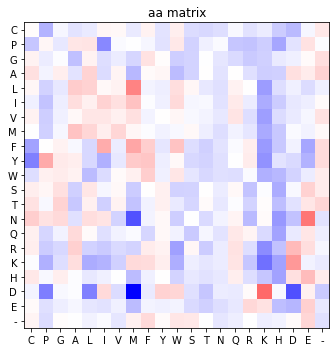

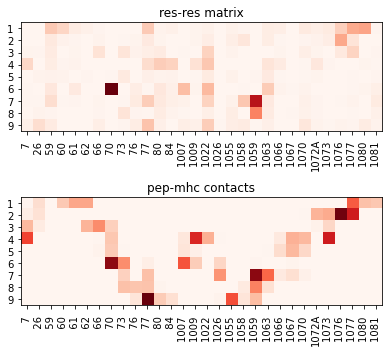

correlation of weights and contacts: 0.5702762721879651


In [280]:
c=0 #which copy to plot

from tfold.nn.pipeline import aa_ext
aa_reordered=list('CPGALIVMFYWSTNQRKHDE-')
ind_aa=[]
for a in aa_reordered:
    ind_aa.append(aa_ext.index(a))
with open('./data/obj/pmhc_contacts_av.pckl','rb') as f:
    contacts=pickle.load(f) #sorted
mhc_resnames=contacts['II']['res'][:n_mhc].values
ind=np.argsort(mhc_resnames)
mhc_resnames=mhc_resnames[ind]
#pep-mhc contacts
with open('./data/experimental_structures/processed_updated/contact_maps_pep-mhc.pckl','rb') as f:
    d=pickle.load(f)
pair_contacts=d['pair_contacts'] #dict (pep,mhc):[contacts]
contact_matrix=np.zeros([n_pep,n_mhc])
for i in range(n_pep):
    for j in range(n_mhc):
        m=int(mhc_resnames[j][:-1])
        if m<1000:
            letter='M'
        else:
            letter='N'        
        contact_matrix[i,j]=np.mean(pair_contacts['II']['P{:4d} '.format(i+1),letter+mhc_resnames[j]])

plt.figure(figsize=(5,5))
w=w_aa[c]
w=w[ind_aa,:]
w=w[:,ind_aa]
w=-w #positive contrib to logKd means negative contrib to energy
if symmetrize:
    w=w+w.T
v=np.max(np.abs(w))
plt.imshow(w,cmap='bwr',vmin=-v,vmax=v)
plt.xticks(np.arange(21),aa_reordered)
plt.yticks(np.arange(21),aa_reordered)
plt.title('aa matrix')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.subplot(211)
n_pep,n_mhc=params['n_pep'],params['n_mhc']
w=w_rr[c].reshape(n_pep,n_mhc)
w=w[:,ind]
plt.imshow(w,cmap='Reds')
plt.xticks(np.arange(n_mhc),mhc_resnames,rotation=90)
plt.yticks(np.arange(n_pep),1+np.arange(n_pep))
plt.title('res-res matrix')
plt.subplot(212)
plt.imshow(contact_matrix,cmap='Reds')
plt.xticks(np.arange(n_mhc),mhc_resnames,rotation=90)
plt.yticks(np.arange(n_pep),1+np.arange(n_pep))
plt.title('pep-mhc contacts')
plt.tight_layout()
plt.show()
print('correlation of weights and contacts:',np.corrcoef(x=w.flatten(),y=contact_matrix.flatten())[0,1])

#32-0,2,4,6: higher l1 makes weights sparser, but correlation only gets worse and becomes negative for #6

In [281]:
#correlation between w_rr averaged over copies and contact matrix
w=w_rr.reshape([w_rr.shape[0],n_pep,n_mhc])
w=w[:,:,ind] #alphabetic order
w=w.reshape([w.shape[0],n_pep*n_mhc])
np.corrcoef(x=np.mean(w,axis=0),y=contact_matrix.flatten())

array([[1.        , 0.59418857],
       [0.59418857, 1.        ]])

# choose mhc pseudoseq

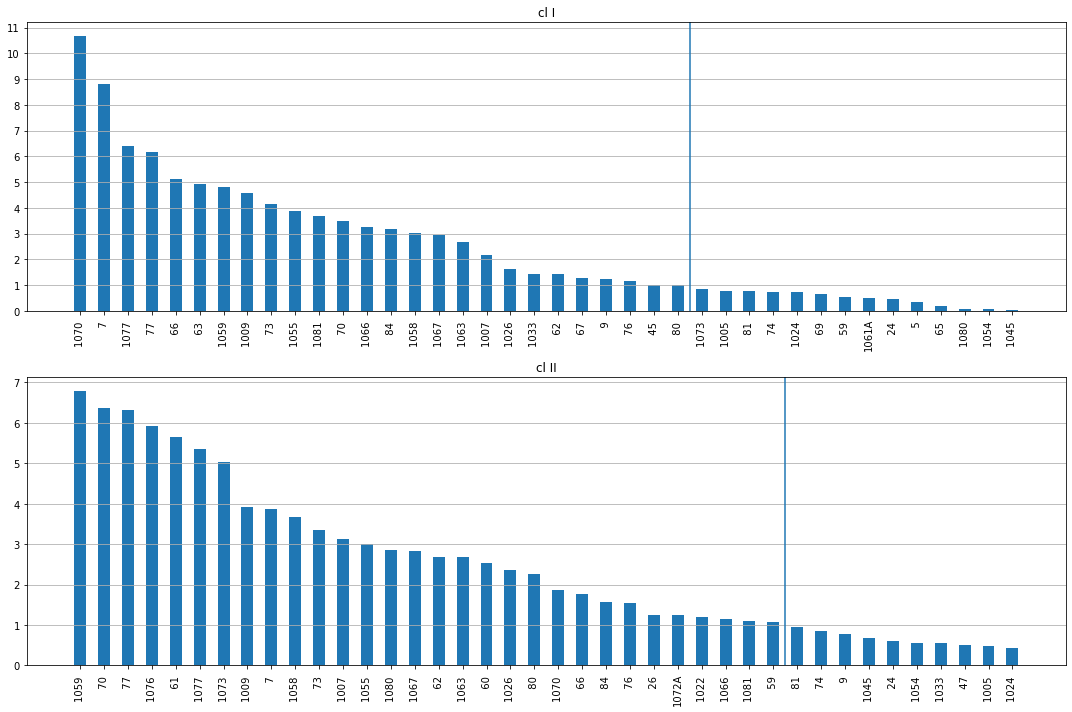

In [11]:
#choose mhc pseudoseq
with open('./data/obj/pmhc_contacts_av.pckl','rb') as f:
    contacts=pickle.load(f) #already sorted
n=40
n_keep1=26
n_keep2=30
x_space=np.arange(n)
plt.figure(figsize=(15,10))
plt.subplot(211)
df=contacts['I'].head(n)
bar1=plt.bar(np.arange(n),df['contacts'],width=0.5)
plt.xticks(np.arange(n),df['res'],rotation=90)
plt.yticks(np.arange(12))
plt.grid(axis='y')
plt.axvline(n_keep1-0.5)
plt.title('cl I')
plt.subplot(212)
df=contacts['II'].head(n)
bar2=plt.bar(np.arange(n),df['contacts'],width=0.5)
plt.xticks(np.arange(n),df['res'],rotation=90)
plt.grid(axis='y')
plt.axvline(n_keep2-0.5)
plt.title('cl II')
plt.tight_layout()
plt.show()

# netmhc performance

In [3]:
train_i=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/train_i.pckl')
train_ii=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/train_ii.pckl')
test_i=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/test_i.pckl')
test_ii=pd.read_pickle('./data/pmhc_assays/netmhc_predictions/test_ii.pckl')
print(len(train_i),len(train_ii),len(test_i),len(test_ii))
kd_pairs=pd.read_pickle('./data/pmhc_assays/iedb_pmhc_assays/kd_pairs.pckl')
kd_pairs=kd_pairs.rename({'kd1':'kd','kd2':'netmhc_kd'},axis=1)
kd_pairs_i=kd_pairs[kd_pairs['class']=='I']
kd_pairs_ii=kd_pairs[kd_pairs['class']=='II']
print(len(kd_pairs_i),len(kd_pairs_ii))
dfs_i= [kd_pairs_i, train_i.sample(1000), test_i ]
dfs_ii=[kd_pairs_ii,train_ii.sample(1000),test_ii]
def log10(x):
    return np.log10(x.values)
s_i=[(log10(x['kd']),log10(x['netmhc_kd'])) for x in dfs_i]
s_ii=[(log10(x['kd']),log10(x['netmhc_kd'])) for x in dfs_ii]
names=['exp','train','test']

199902 115836 399 472
1628 107


In [5]:
#assays, mhcs, species
len(train_i),len(train_i['mhc_a'].unique()),len(np.unique(train_i['mhc_a'].map(lambda x:x[0]).values))

(199902, 161, 7)

In [6]:
#assays, mhcs, species
tiimhc=train_ii.apply(lambda x:(x['mhc_a'],x['mhc_b']),axis=1)
len(train_ii),len(tiimhc.unique()),len(np.unique(train_ii['mhc_a'].map(lambda x:x[0]).values))

(115836, 83, 3)

In [7]:
#mhcs in test set
x1=test_i['mhc_iedb'].value_counts()
x2=test_ii['mhc_iedb'].value_counts()
print(len(x1),len(x2))
print(x1,x2)

19 27
HLA-A*02:01    55
HLA-B*07:02    47
HLA-A*01:01    46
HLA-B*44:02    43
HLA-A*03:01    39
HLA-A*33:03    38
HLA-A*24:02    32
HLA-B*15:01    20
HLA-A*26:01    14
HLA-B*18:01    11
HLA-C*01:02    10
HLA-E*01:01     9
HLA-B*44:03     8
HLA-B*51:01     7
HLA-B*14:02     6
HLA-B*08:01     6
HLA-E*01:03     6
HLA-C*07:01     1
HLA-A*11:01     1
Name: mhc_iedb, dtype: int64 HLA-DRB1*04:01               79
HLA-DRB1*03:01               27
HLA-DRB1*07:01               27
HLA-DRB1*11:01               27
HLA-DRB1*08:02               25
HLA-DRB1*09:01               25
HLA-DRB1*13:02               25
HLA-DRB1*04:02               24
HLA-DRB1*01:01               23
HLA-DRB1*15:01               20
HLA-DRB5*01:01               18
HLA-DRB4*01:01               18
HLA-DRB3*02:02               18
HLA-DRB3*01:01               18
HLA-DRB1*12:01               18
HLA-DRB1*04:05               18
HLA-DQA1*01:02/DQB1*06:02     8
HLA-DQA1*01:01/DQB1*05:01     7
HLA-DQA1*02:01/DQB1*02:02     7
HLA-DQA1*05:01/

In [8]:
#error and corr coef (incl whole training sets)
print('class I')
df=train_i
x1=np.log10(df['kd']).values
x2=np.log10(df['netmhc_kd']).values
err2=np.average((x1-x2)**2)
print('train: rms error {:5.3f} (squared {:5.3f}), corr. coef. {:5.3f}'.format(err2**0.5,err2,np.corrcoef([x1,x2])[0,1]))
df=test_i
x1=np.log10(df['kd']).values
x2=np.log10(df['netmhc_kd']).values
err2=np.average((x1-x2)**2)
print('test : rms error {:5.3f} (squared {:5.3f}), corr. coef. {:5.3f}'.format(err2**0.5,err2,np.corrcoef([x1,x2])[0,1]))
print()
print('class II')
df=train_ii
x1=np.log10(df['kd']).values
x2=np.log10(df['netmhc_kd']).values
err2=np.average((x1-x2)**2)
print('train: rms error {:5.3f} (squared {:5.3f}), corr. coef. {:5.3f}'.format(err2**0.5,err2,np.corrcoef([x1,x2])[0,1]))
df=test_ii
x1=np.log10(df['kd']).values
x2=np.log10(df['netmhc_kd']).values
err2=np.average((x1-x2)**2)
print('test : rms error {:5.3f} (squared {:5.3f}), corr. coef. {:5.3f}'.format(err2**0.5,err2,np.corrcoef([x1,x2])[0,1]))

class I
train: rms error 0.620 (squared 0.384), corr. coef. 0.884
test : rms error 1.285 (squared 1.651), corr. coef. 0.615

class II
train: rms error 0.707 (squared 0.500), corr. coef. 0.822
test : rms error 1.019 (squared 1.039), corr. coef. 0.465


In [9]:
def sens_spec(x): #x=[true scores, predicted scores]
    threshold=np.log(500)/np.log(10)
    i_p=x[0]<=threshold
    i_ip=x[1]<=threshold
    n_tp=np.sum(i_p&i_ip)
    n_p=np.sum(i_p)
    n_tn=np.sum((~i_p)&(~i_ip))
    n_n=np.sum(~i_p)    
    return n_tp/n_p,n_tn/n_n #sensitivity, specificity (1-fpr)

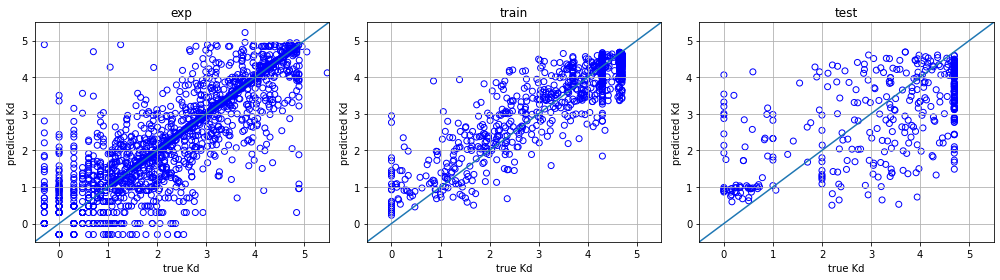

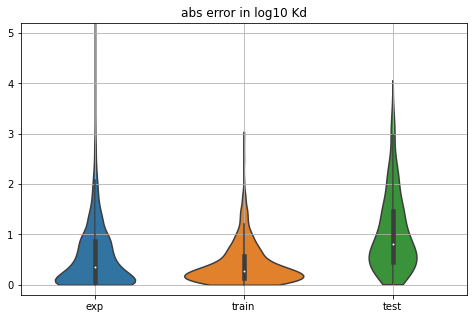

sensitivity, specificity:
exp       :  0.92  0.85
train     :  0.80  0.98
test      :  0.72  0.78
linear correlation:
exp       :  0.820
train     :  0.895
test      :  0.615


In [10]:
s=s_i
n=len(s)
xmin=-0.5
xmax=5.5
plt.figure(figsize=(14,4))
for i,ss in enumerate(s):
    plt.subplot(1,n,i+1)
    plt.grid()
    #plt.scatter(ss[0],ss[1]-ss[0])
    #plt.xlim(-1.5,6)
    #plt.ylim(-6,6)        
    plt.scatter(ss[0],ss[1],edgecolors='blue',facecolors='none')
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)  
    plt.plot([xmin,xmax],[xmin,xmax])
    plt.xlabel('true Kd')
    plt.ylabel('predicted Kd')
    plt.title(names[i])    
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,5))
sns.violinplot(data=[np.abs(ss[0]-ss[1]) for ss in s],cut=0)
plt.xticks(np.arange(len(s)),names)
plt.grid()
plt.ylim(-0.2,5.2)
plt.title('abs error in log10 Kd')
plt.show()
print('sensitivity, specificity:')
for n,x in zip(names,s):
    print('{:10s}:  {:4.2f}  {:4.2f}'.format(n,*sens_spec(x)))   
print('linear correlation:')
for n,x in zip(names,s):
    print('{:10s}:  {:5.3f}'.format(n,np.corrcoef(x)[0,1]))

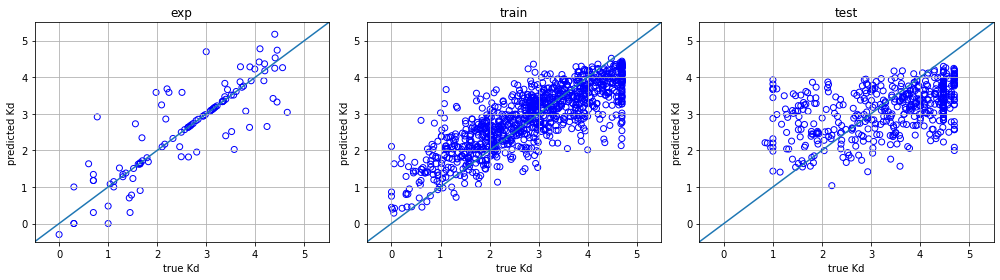

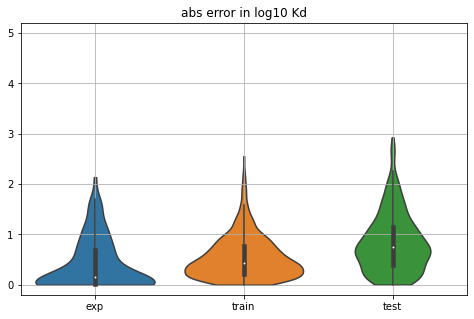

sensitivity, specificity:
exp       :  0.83  0.89
train     :  0.79  0.89
test      :  0.53  0.84
linear correlation:
exp       :  0.859
train     :  0.820
test      :  0.465


In [11]:
s=s_ii
n=len(s)
xmin=-0.5
xmax=5.5
plt.figure(figsize=(14,4))
for i,ss in enumerate(s):
    plt.subplot(1,n,i+1)
    plt.grid()
    #plt.scatter(ss[0],ss[1]-ss[0])
    #plt.xlim(-1.5,6)
    #plt.ylim(-6,6)        
    plt.scatter(ss[0],ss[1],edgecolors='blue',facecolors='none')
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)  
    plt.plot([xmin,xmax],[xmin,xmax])
    plt.xlabel('true Kd')
    plt.ylabel('predicted Kd')     
    plt.title(names[i])    
plt.tight_layout()
plt.show()
plt.figure(figsize=(8,5))
sns.violinplot(data=[np.abs(ss[0]-ss[1]) for ss in s],cut=0)
plt.xticks(np.arange(len(s)),names)
plt.ylim(-0.2,5.2)
plt.grid()
plt.title('abs error in log10 Kd')
plt.show()
print('sensitivity, specificity:')
for n,x in zip(names,s):
    print('{:10s}:  {:4.2f}  {:4.2f}'.format(n,*sens_spec(x)))  
print('linear correlation:')
for n,x in zip(names,s):
    print('{:10s}:  {:5.3f}'.format(n,np.corrcoef(x)[0,1]))

# trash

## explore netmhc training sets

In [11]:
print(os.listdir('./data/pmhc_assays/netmhcpan_i41_ii40'))
print(os.listdir('./data/pmhc_assays/netmhcpan_i41_ii40/NetMHCpan_train'))
print(os.listdir('./data/pmhc_assays/netmhcpan_i41_ii40/NetMHCIIpan_train'))

['assays_i.pckl', 'assays_ii.pckl', 'NetMHCpan_train', 'NetMHCIIpan_train', 'NetMHCpan_test', 'NetMHCIIpan_test']
['allelelist', 'c003_ba', 'c003_el', 'c002_ba', 'c002_el', 'c000_el', 'c000_ba', 'c001_el', 'c001_ba', 'c004_ba', 'c004_el', 'MHC_pseudo.dat']
['test_EL1.txt', 'pseudosequence.2016.all.X.dat', 'test_BA4.txt', 'test_BA3.txt', 'train_EL3.txt', 'train_EL4.txt', 'train_BA1.txt', 'test_BA2.txt', 'test_BA5.txt', 'allelelist.txt', 'train_EL5.txt', 'train_EL2.txt', 'train_BA3.txt', 'train_BA4.txt', 'train_EL1.txt', 'test_BA1.txt', 'test_EL4.txt', 'test_EL3.txt', 'train_BA5.txt', 'train_BA2.txt', 'test_EL2.txt', 'test_EL5.txt']
